In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from dtaidistance import dtw



In [2]:
file_path = 'D:\Hiwi-TimeSeries\dataset\Versuch1_final.csv'
df = pd.read_csv(file_path, delimiter=';', decimal=',')
df = df.head(100000)

## Functions

In [3]:
def rename_columns(dataframe):
    renamed_columns = []
    for column in dataframe.columns:
        parts = column.split('_')
        if len(parts) >= 3:
            if parts[0] == 'Geschw':
                new_column = 'Speed_' + parts[1]
            elif parts[0] == 'Beschl':
                new_column = 'Accel_' + parts[1]
            elif parts[0] == 'Kraft':
                new_column = 'Power_' + parts[1]
            elif parts[0] == 'Current':
                new_column = 'Current_' + parts[1]
        else:
            new_column = column
        renamed_columns.append(new_column)
    
    dataframe.columns = renamed_columns
    return dataframe

In [64]:
def plot_prediction(y_test, y_pred, title):
    plt.figure(figsize=(16, 4))
    num_points = min(len(y_test), 10000)
    x_values = np.arange(num_points)
    plt.plot(x_values, y_test[:num_points], label='Actual Current', alpha=0.7)
    plt.plot(x_values, y_pred[:num_points], label='Predicted Current', alpha=0.5)
    plt.ylim(0, 30)  # Set y-axis limits from 0 to 30
    plt.xlabel('Index')
    plt.ylabel('Current')
    plt.title('Actual vs. Predicted Current -' + title)
    plt.legend()
    plt.show()


In [5]:
def dtw_distbance(y_test, y_pred):
    predicted = np.array(y_pred)
    actual = np.array(y_test)
    distance = dtw.distance(predicted, actual)
    print(f"DTW Distance: {distance}")

In [6]:
def fit_predict(model, X_train, X_test, y_train, y_test, title):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #print(y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    #dtw_dist = dtw_distbance(y_test, y_pred)

    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    print("R-squared Score:", r2)
    print("Mean Absolute Percentage Error:", mape)
    #print("DTW Distance:", dtw_dist)

    plot_prediction(y_test, y_pred, title)
    #return y_pred
    #residual_analysis(y_test, y_pred)

In [49]:
def neural_nets(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    nn_model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=[X_train_scaled.shape[1]]),
        keras.layers.Dropout(0.2),  # Adding dropout for regularization
        keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Regularization
        keras.layers.Dropout(0.2),  # Adding dropout for regularization
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1)  # Output layer with single neuron for regression
    ])

    # Compile the model
    nn_model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.3, verbose=0)

    # Predict on the test set
    y_pred = nn_model.predict(X_test_scaled).flatten()

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    print("R-squared Score:", r2)
    print("Mean Absolute Percentage Error:", mape)

    plot_prediction(y_test, y_pred)

## Pre-processing and Data Split

In [7]:
df.drop('removed_material_0', axis=1, inplace=True)
df = rename_columns(df)

In [58]:
X = df.drop(columns=['Current_X', 'Current_Y', 'Current_Z', 'Current_SP'])
y = df[['Current_X', 'Current_Y', 'Current_Z', 'Current_SP']].sum(axis=1)
split_index = int(0.7 * len(df))

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
#X_train.loc[:, 'Current'] = y_train


In [74]:
print(df.describe())

             Speed_X        Speed_Y       Speed_Z       Speed_SP  \
count  100000.000000  100000.000000  1.000000e+05  100000.000000   
mean       23.444132      31.101163 -3.364507e+01    2463.825245   
std      1364.409111    1494.617762  1.785910e+03    2130.709706   
min    -30002.623902  -29758.186098 -3.000291e+04      -0.080945   
25%       -42.894329     -84.754207 -2.707861e-18    1099.999126   
50%         0.000000       0.000000  0.000000e+00    1700.000299   
75%       139.916341      16.849756  6.585366e-03    3150.014179   
max     21696.424390   30000.580976  3.000358e+04    7623.721799   

             Accel_X       Accel_Y       Accel_Z       Accel_SP   Power_X  \
count  100000.000000  1.000000e+05  1.000000e+05  100000.000000  100000.0   
mean       -0.000002  4.728658e-07 -4.431707e-07       0.139255       0.0   
std         0.087734  9.891850e-02  1.268151e-01       5.084449       0.0   
min        -2.377372 -2.871701e+00 -3.763933e+00     -80.259824       0.0   
25

# Baseline Model

## PyCaret

The best regression model can be found out by using the pycaret library.

In [8]:
from pycaret.regression import *

reg_setup = setup(X_train, target='Current', fold=5, fold_strategy='timeseries', train_size=0.7, data_split_shuffle=False)
best_models = compare_models(n_select=7)

,Description,Value
0,Session id,175
1,Target,Current
2,Target type,Regression
3,Original data shape,"(70000, 13)"
4,Transformed data shape,"(70000, 13)"
5,Transformed train set shape,"(49000, 13)"
6,Transformed test set shape,"(21000, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.3774,0.7724,0.7808,-0.1767,0.0878,0.0622,1.8360
knn,K Neighbors Regressor,0.3724,0.8021,0.7941,-0.2942,0.0892,0.0608,0.1680
rf,Random Forest Regressor,0.4015,0.7876,0.8002,-0.3643,0.0924,0.0667,3.4640
gbr,Gradient Boosting Regressor,0.3563,0.7212,0.7701,-0.5027,0.0847,0.0573,1.0600
lasso,Lasso Regression,0.4705,0.9082,0.8541,-0.6256,0.1005,0.0769,0.6900
llar,Lasso Least Angle Regression,0.4705,0.9083,0.8541,-0.6256,0.1005,0.0769,0.0160
en,Elastic Net,0.4720,0.9157,0.8582,-0.6418,0.0998,0.0772,0.0200
lightgbm,Light Gradient Boosting Machine,0.4738,1.0189,0.8952,-0.6529,0.1056,0.0801,0.1180
ridge,Ridge Regression,0.4721,0.9090,0.8576,-0.6559,0.0993,0.0774,0.0200
br,Bayesian Ridge,0.4722,0.9098,0.8581,-0.6582,0.0994,0.0774,0.0220


In [9]:
print(best_models)

[RandomForestRegressor(n_jobs=-1, random_state=3939), <catboost.core.CatBoostRegressor object at 0x0000011F4237DA10>, LGBMRegressor(n_jobs=-1, random_state=3939), XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=3939, ...), KNeighborsRegressor(n_jobs=-1), DecisionTreeRegressor(random_state=3939), GradientBoos

In [11]:
model_metrics = []

for model in best_models:
    final_model = finalize_model(model)
    y_pred = predict_model(final_model, data=X_test)['prediction_label']
    model_name = str(model).split("(")[0]
    #y_pred_values = y_pred.iloc[:, -1].values
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    model_metrics.append({'Model': model_name,
                          'RMSE': rmse,
                          'MAE': mae,
                          'MSE': mse,
                          'R2': r2,
                          'MAPE': mape})

In [12]:
model_metrics_df = pd.DataFrame(model_metrics)
print(model_metrics_df)

                       Model      RMSE       MAE       MSE        R2      MAPE
0        ExtraTreesRegressor  0.462318  0.096921  0.213738  0.781415  1.528927
1        KNeighborsRegressor  0.554141  0.118496  0.307072  0.685963  1.838320
2      RandomForestRegressor  0.442818  0.101628  0.196087  0.799465  1.582356
3  GradientBoostingRegressor  0.713133  0.197547  0.508558  0.479908  2.928484
4                      Lasso  0.974070  0.344060  0.948812  0.029669  5.193220
5                  LassoLars  0.974070  0.344060  0.948811  0.029669  5.193215
6                 ElasticNet  0.974027  0.344008  0.948729  0.029754  5.192429


## Random Forest Regressor

In [26]:
rf_model = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [27]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [28]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
28 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda\Lib\site-packages\sklearn\ensemble\_forest.py", line 489, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "d:\anaconda\Lib\site-

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

Mean Absolute Error: 0.10106439544849866
Mean Squared Error: 0.19553724337216402
Root Mean Squared Error: 0.4421959332379302
R-squared Score: 0.8000279730070741
Mean Absolute Percentage Error: 1.5867894630739294


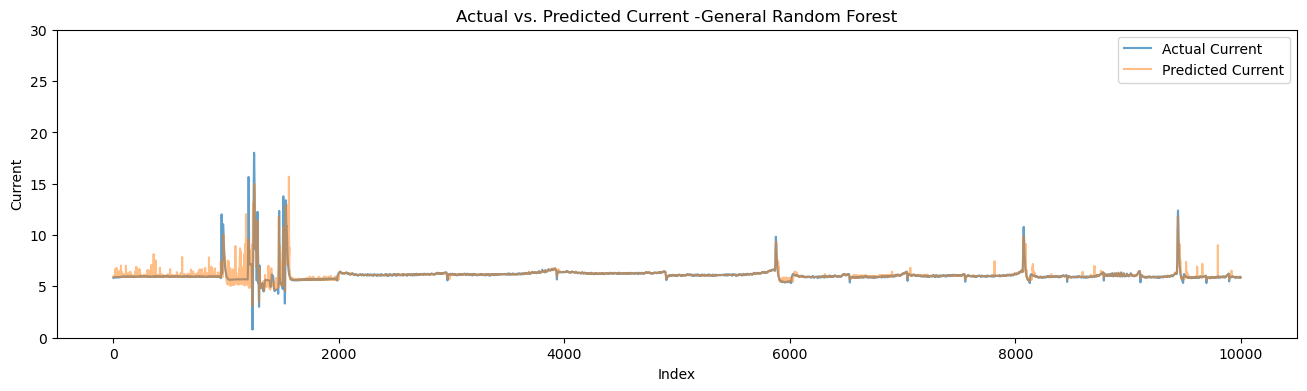

In [49]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=3939)
fit_predict(rf_model, X_train, X_test, y_train, y_test, 'General Random Forest')

In [29]:
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 20,
 'bootstrap': False}

In [30]:
best_random = rf_random.best_estimator_
print(best_random)

RandomForestRegressor(bootstrap=False, max_depth=20, max_features='log2',
                      n_estimators=1800)


Mean Absolute Error: 0.11224343356870012
Mean Squared Error: 0.2163959626928869
Root Mean Squared Error: 0.4651837945295246
R-squared Score: 0.7786961780451161
Mean Absolute Percentage Error: 1.7102503247676912


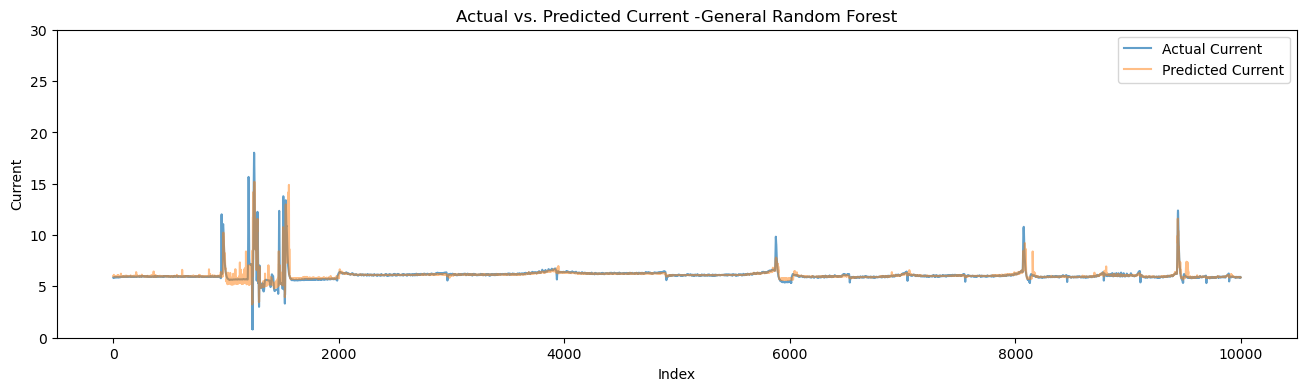

In [31]:
best_random = rf_random.best_estimator_
fit_predict(best_random, X_train, X_test, y_train, y_test, 'General Random Forest')

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [False],
    'max_depth': [15, 20, 25, 30],
    'max_features': ['log2'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [1500, 1800, 2000, 2200]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [33]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


d:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
23 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\anaconda\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda\Lib\site-packages\sklearn\ensemble\_forest.py", line 489, in fit
    trees = Parallel(
            ^^^^^^^^^
  File "d:\anaconda\Lib\site-p

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1500}

In [67]:
best_grid = RandomForestRegressor(bootstrap= False, max_depth= 20, max_features= 'log2', min_samples_leaf= 1,
 min_samples_split= 2, n_estimators= 1500)

Mean Absolute Error: 0.11188401061157058
Mean Squared Error: 0.21553315578395485
Root Mean Squared Error: 0.4642554854645822
R-squared Score: 0.7795785534100703
Mean Absolute Percentage Error: 1.708125042700187


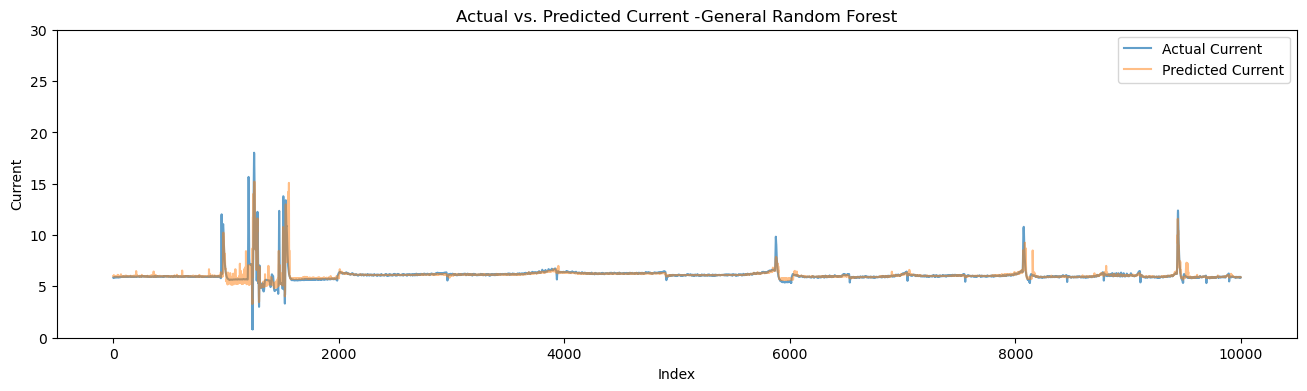

In [34]:
best_grid = grid_search.best_estimator_
grid_accuracy = fit_predict(best_grid, X_train, X_test, y_train, y_test, 'General Random Forest')

## Neural Networks

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step
Mean Absolute Error: 0.3807172490107514
Mean Squared Error: 0.9285406729065226
Root Mean Squared Error: 0.9636081531963719
R-squared Score: 0.05040002966040691
Mean Absolute Percentage Error: 5.938841674617338


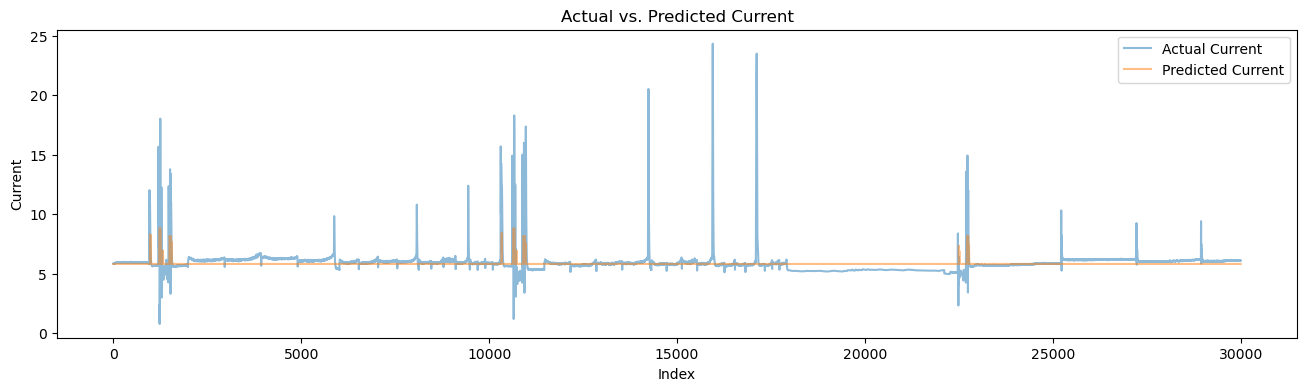

In [31]:
neural_nets(X_train, X_test, y_train, y_test)

# Peak Detection

In [17]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(len(y)):
        threshold = np.mean(y[i-lag:i])
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [33]:
def detect_peaks(y, lag):
    peaks = []
    threshold = np.mean(y[:lag])
    for i in range(len(y)):
        if y[i] > threshold*1.1:
            peaks.append(i)
        threshold = np.mean(y[i:lag+i])
    return peaks


In [37]:
def get_peak_indices_by_column(dataframe, lag):
    peak_indices_by_column = {}

    for column_name in dataframe.columns:
        result = detect_peaks(dataframe[column_name], lag)
        #peak_indices = [i for i in enumerate(result)]
        peak_indices_by_column[column_name] = result

    return peak_indices_by_column

In [19]:
import itertools

def find_common_peaks(peaks_df):
    common_peaks = []
    
    columns = peaks_df['Column_Name'].tolist()
    columns.remove('Current')
    column_combinations = [(column, 'Current') for column in columns]   

    for pair in column_combinations:
        column1_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[0], 'Peak_Indices'].iloc[0])
        column2_peaks = set(peaks_df.loc[peaks_df['Column_Name'] == pair[1], 'Peak_Indices'].iloc[0])
        
        common_indices = list(column1_peaks.intersection(column2_peaks))
        num_common_peaks = len(common_indices)
        
        common_peaks.append({'feature_pair': pair, 'peak_indices': common_indices, 'num_peaks': num_common_peaks})
    
    return pd.DataFrame(common_peaks)

In [48]:
def plot_common_peaks(df, common_peaks_df, lag):
    for index, row in common_peaks_df.iterrows():
        pair = row['feature_pair']
        common_indices = sorted(row['peak_indices'])
        
        values_column1 = []
        index_column = []
        values_column2 = []
        
        for index_value in common_indices:
            # Extract values for both columns from 10 indices before and after the common index
            values_column1.extend(df.loc[index_value - 10:index_value + 10, pair[0]].tolist())
            values_column2.extend(df.loc[index_value - 10:index_value + 10, pair[1]].tolist())
            if index_value > 10:
                index_column.extend(list(range(index_value - 10, index_value + 11)))
                
        #values_column1 = (values_column1 - np.min(values_column1)) / (np.max(values_column1) - np.min(values_column1))
        #values_column2 = (values_column2 - np.min(values_column2)) / (np.max(values_column2) - np.min(values_column2))
        values_column1 = [(value - np.min(values_column1)) / (np.max(values_column1) - np.min(values_column1)) for value in values_column1]
        values_column2 = [(value - np.min(values_column2)) / (np.max(values_column2) - np.min(values_column2)) * (2 - 1) + 1 for value in values_column2]
        plt.figure(figsize=(12, 4))
        plt.plot(index_column, values_column1, label=pair[0])
        plt.plot(index_column, values_column2, label=pair[1])
    
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.title('Common Peaks --' + str(row['num_peaks']) +' (Lag = ' + str(lag) + ')')
        plt.legend()
        plt.show()


In [47]:
def get_output_peaks(df, lag):  
    peak_info = get_peak_indices_by_column(df, lag)
    peaks_df = pd.DataFrame({'Column_Name': list(peak_info.keys()), 
                                'Peak_Indices': list(peak_info.values())})
    peaks_df['Num_Peaks'] = peaks_df['Peak_Indices'].apply(len)
    peaks_df = peaks_df[~peaks_df['Column_Name'].str.startswith('Power')]
    #print(peaks_df.head(10))

    common_peaks_df = find_common_peaks(peaks_df)
    plot_common_peaks(df, common_peaks_df, lag)
    #print(common_peaks_df)

    import os
    output_folder = 'D:\Hiwi-TimeSeries\output'

    filename = os.path.join(output_folder, f'common_peaks_l_{lag}.xlsx')
    common_peaks_df.to_excel(filename, sheet_name='common_peaks', index=False)
    print("Currently on lag:", lag)


In [38]:
pi= get_peak_indices_by_column(df, 10000)

In [39]:
peaks_df = pd.DataFrame({'Column_Name': list(pi.keys()), 
                                'Peak_Indices': list(pi.values())})
peaks_df['Num_Peaks'] = peaks_df['Peak_Indices'].apply(len)
peaks_df = peaks_df[~peaks_df['Column_Name'].str.startswith('Power')]
print(peaks_df)

   Column_Name                                       Peak_Indices  Num_Peaks
0      Speed_X  [599, 600, 601, 602, 603, 604, 605, 606, 607, ...      50092
1      Speed_Y  [599, 600, 601, 602, 603, 604, 605, 606, 607, ...      24379
2      Speed_Z  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...      51018
3     Speed_SP  [6869, 6870, 6871, 6872, 6873, 6874, 6875, 687...      20411
4      Accel_X  [0, 1, 2, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, ...      51061
5      Accel_Y  [7, 14, 16, 17, 21, 25, 30, 35, 37, 41, 42, 45...      49158
6      Accel_Z  [0, 1, 2, 4, 6, 9, 10, 12, 14, 16, 21, 25, 27,...      52306
7     Accel_SP  [648, 649, 650, 651, 652, 653, 654, 655, 656, ...      22620
12   Current_X  [576, 577, 578, 579, 580, 581, 582, 583, 584, ...      41405
13   Current_Y  [160, 161, 162, 163, 164, 165, 166, 167, 168, ...      31548
14   Current_Z  [360, 361, 362, 363, 364, 365, 366, 379, 380, ...       1661
15  Current_SP  [628, 629, 630, 631, 632, 633, 634, 635, 636, ...      42606

Just checking to see if the plot function is working. 

### Peaks in the training data

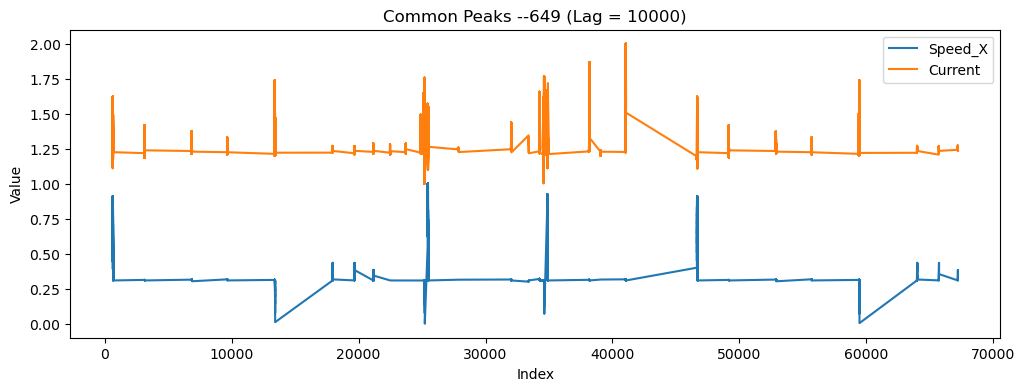

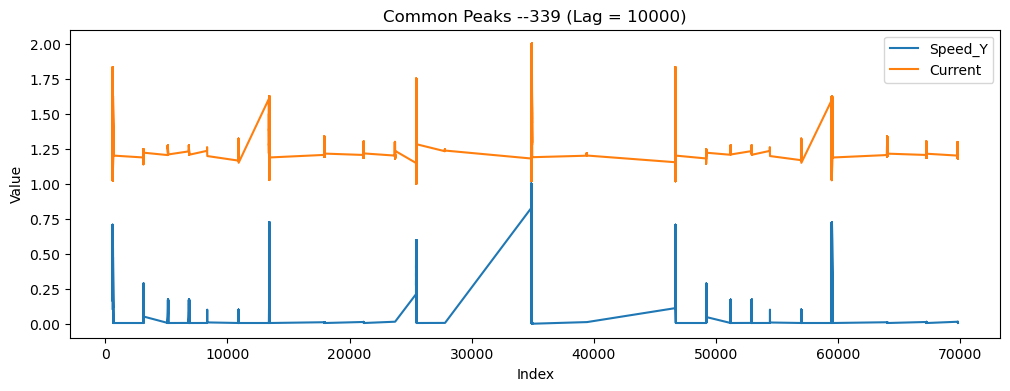

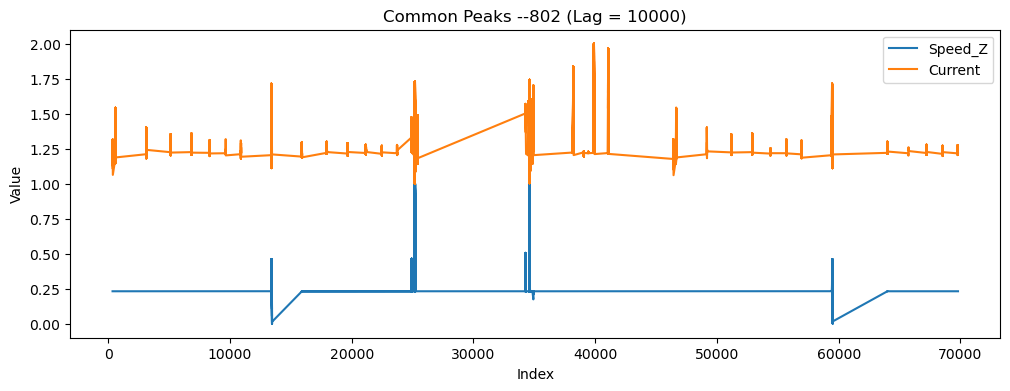

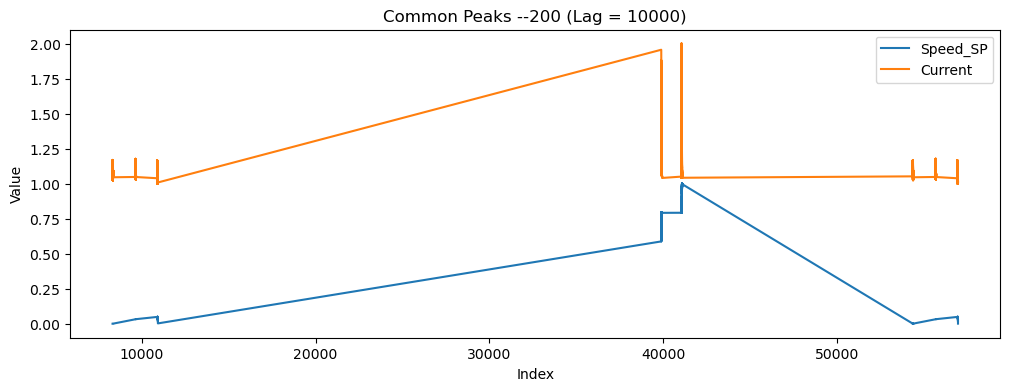

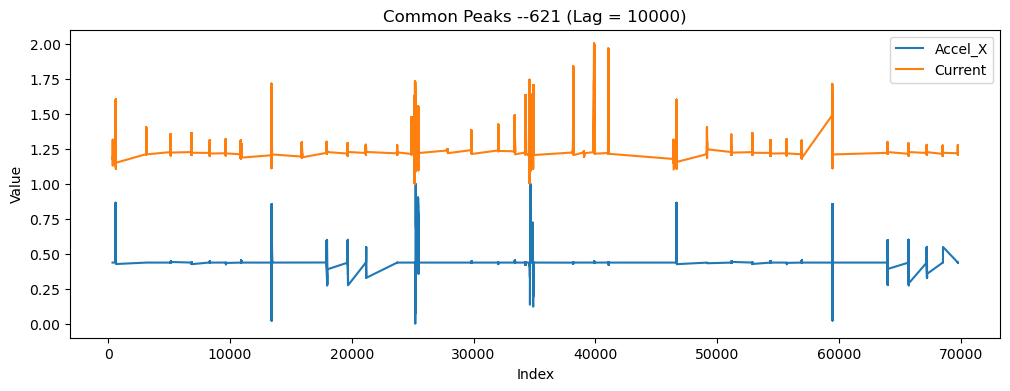

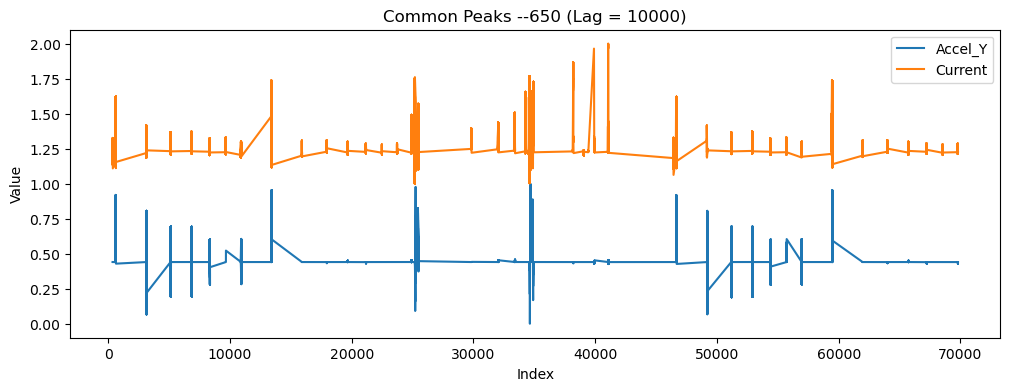

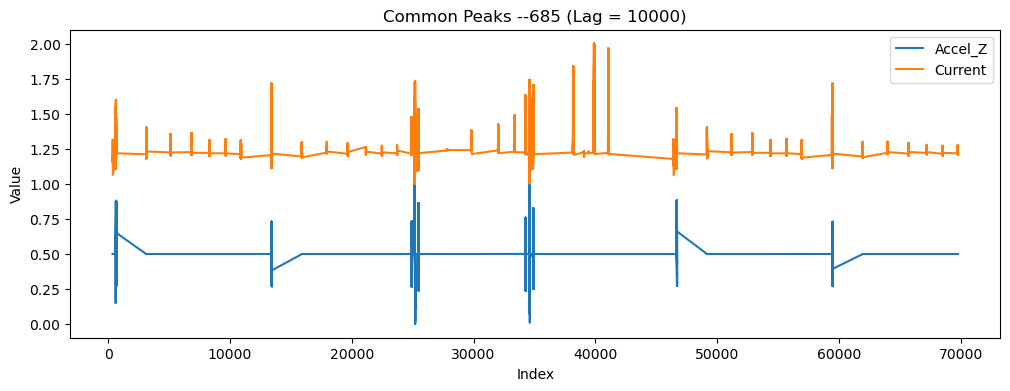

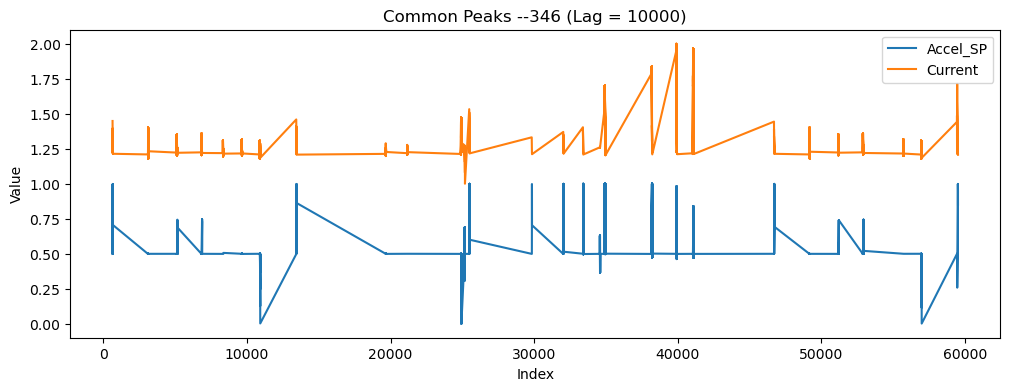

Currently on lag: 10000


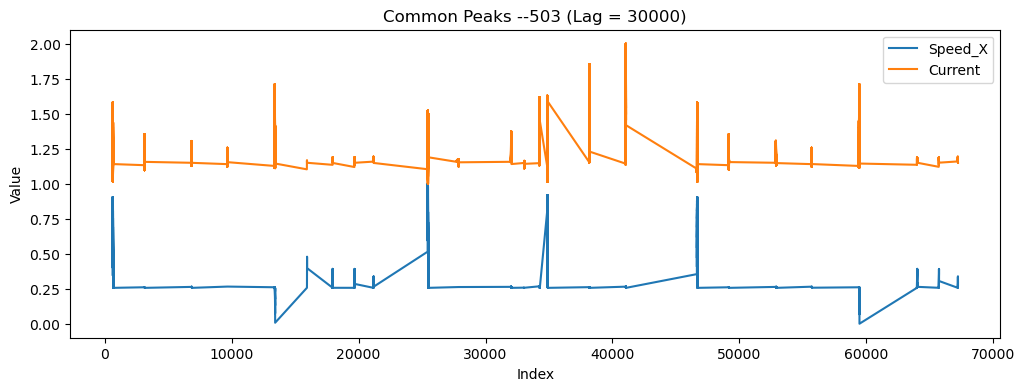

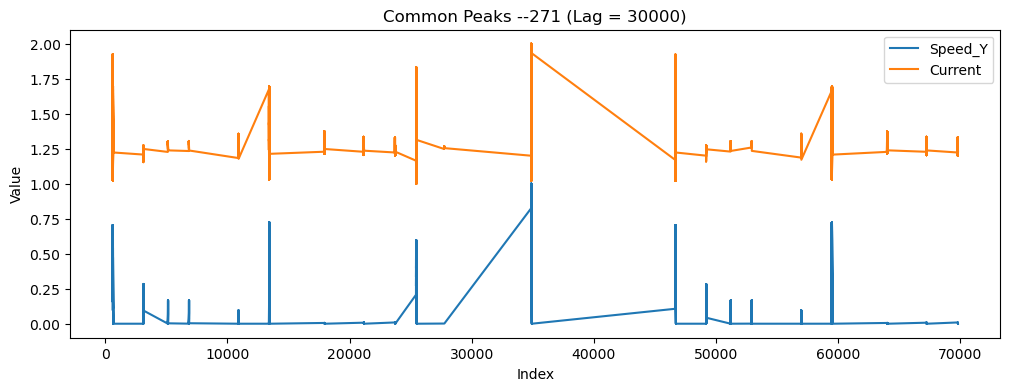

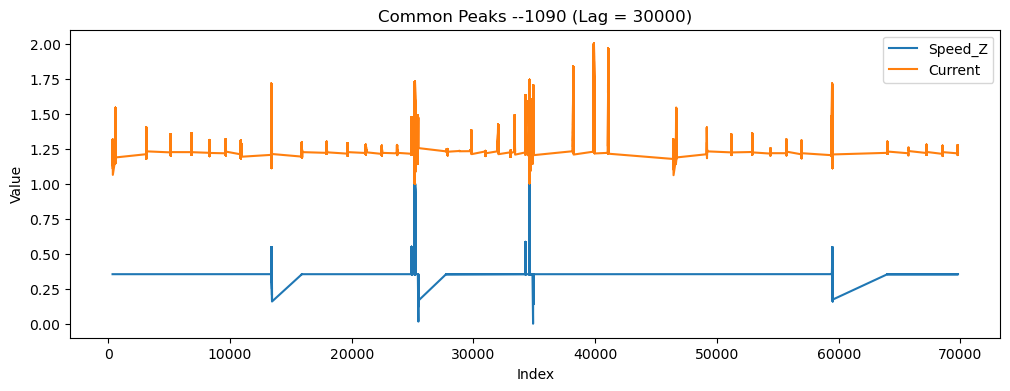

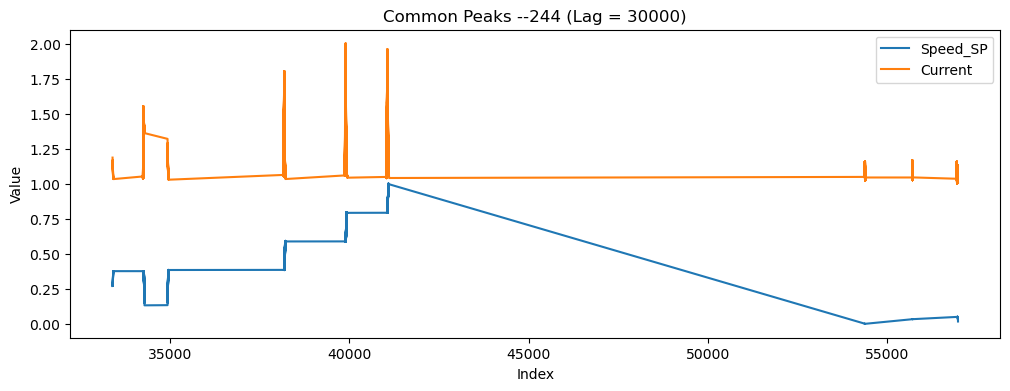

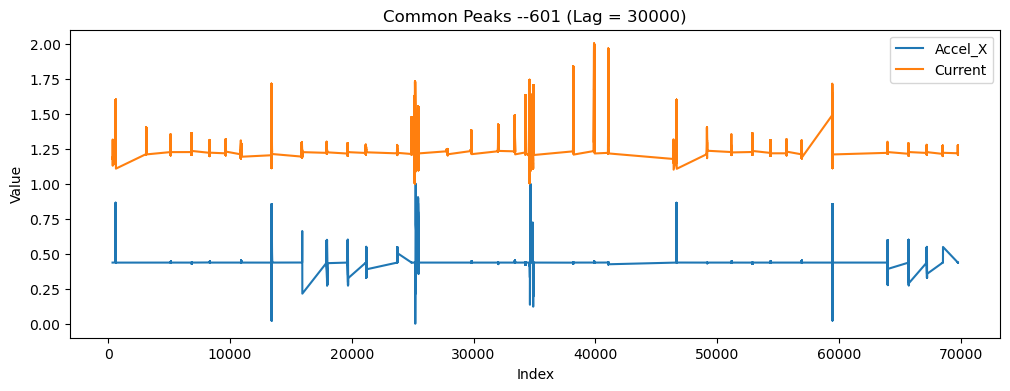

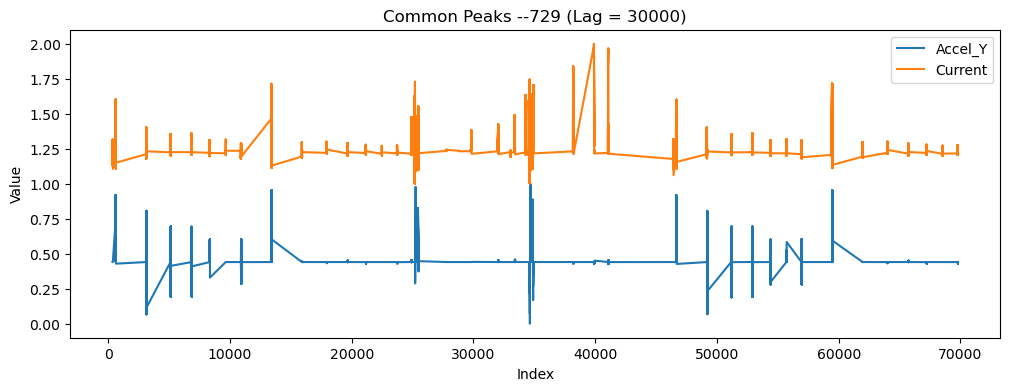

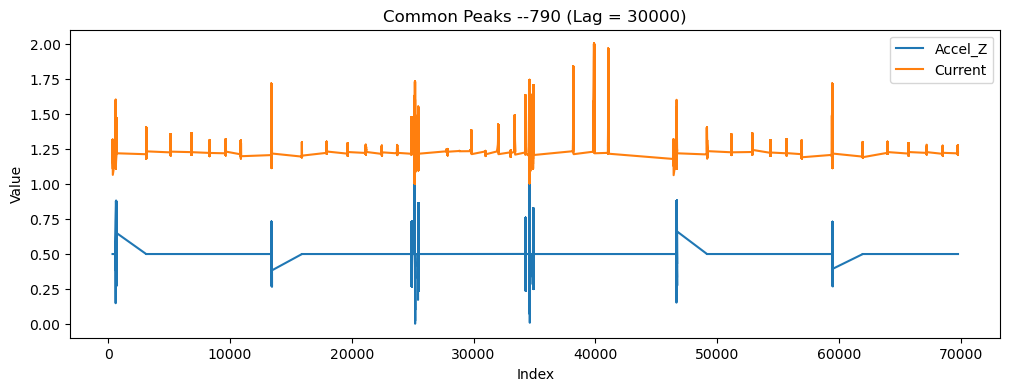

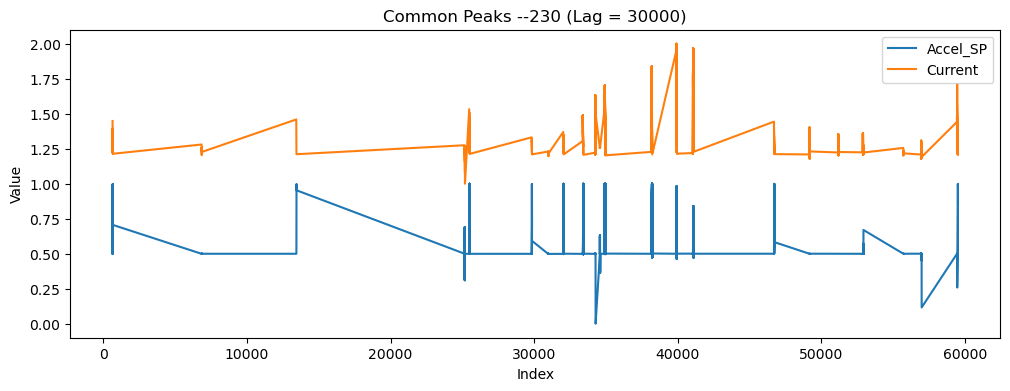

Currently on lag: 30000


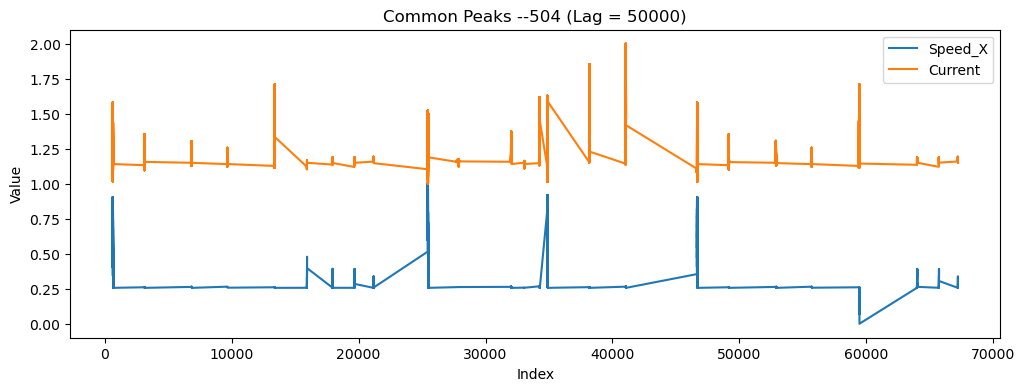

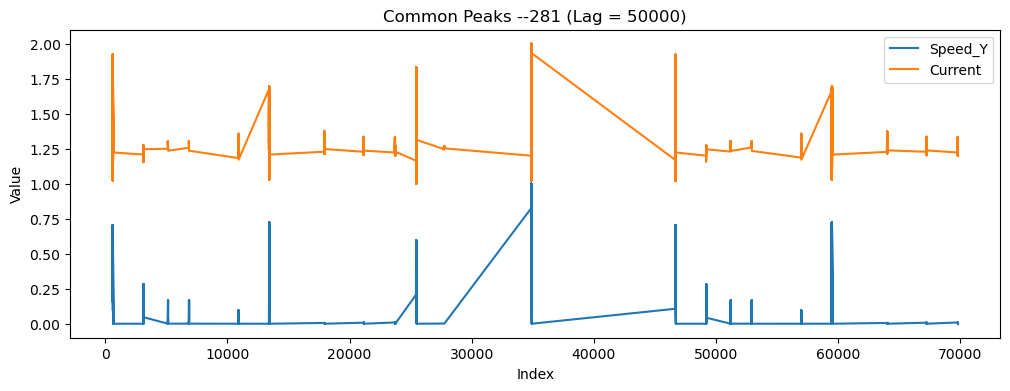

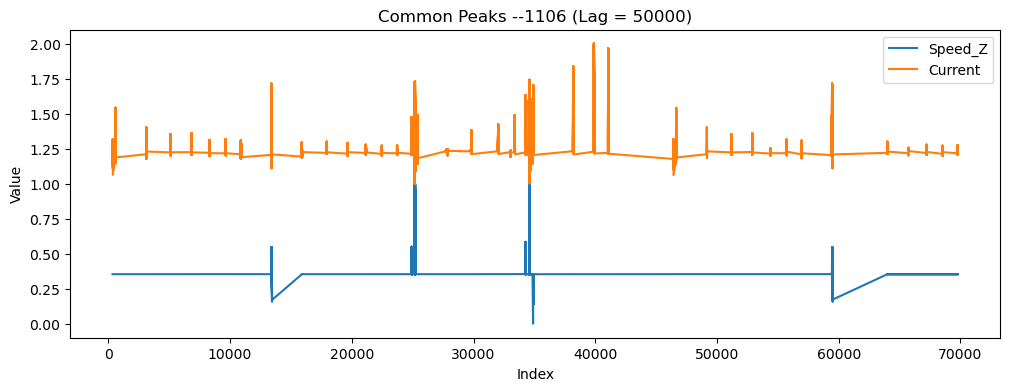

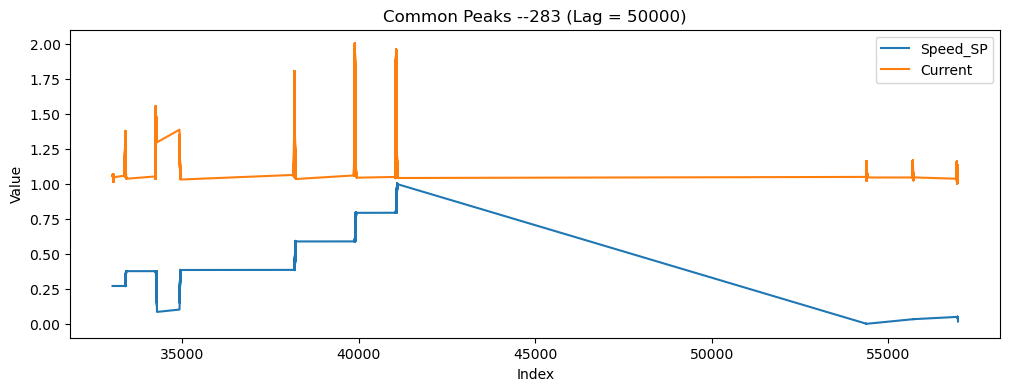

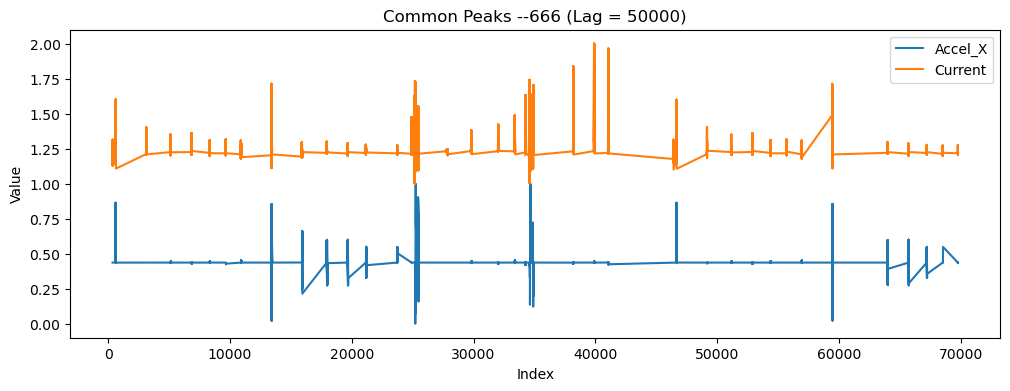

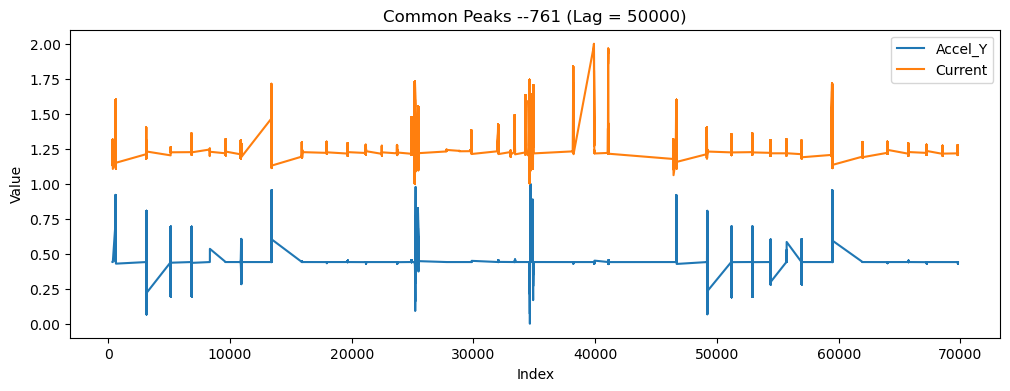

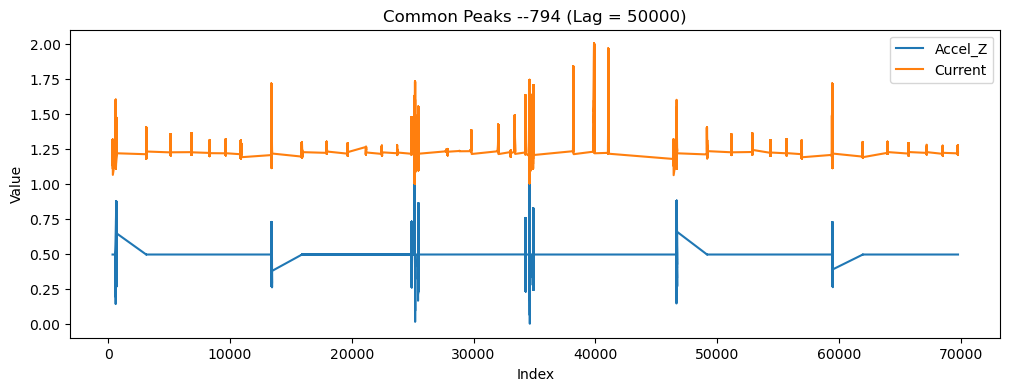

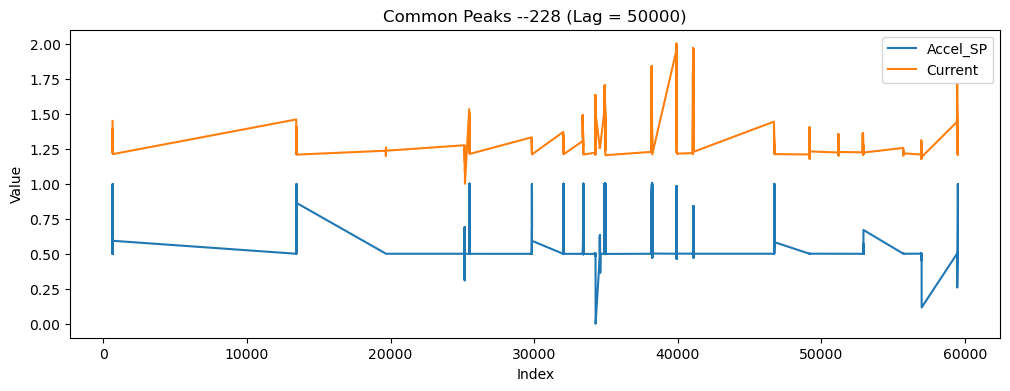

Currently on lag: 50000


In [49]:
X_train.loc[:, 'Current'] = y_train
lag = [10000, 30000, 50000]
for lag_val in lag:
    get_output_peaks(X_train, lag_val)


# Peak Aware Model

We have chosen lag = 10000 and influence = 0.1 as the parameters for the peak detection methods. Based on this, separate peaks and non-peaks into two different dfs.

In [50]:
peak_info = pd.read_excel('D:\Hiwi-TimeSeries\output\common_peaks_l_50000.xlsx')
max_peaks = peak_info[peak_info['num_peaks'] == peak_info['num_peaks'].max()]


Check if many features have common peaks or only one.

In [51]:
peak_indices_lists = max_peaks['peak_indices'].tolist()
all_indices_same = all(peak_indices == peak_indices_lists[0] for peak_indices in peak_indices_lists)
same = 0
if all_indices_same:
    same = 1
    print("All peak indices are the same across all rows.")
else:
    print("Peak indices are not the same across all rows.")


All peak indices are the same across all rows.


Based on that, create two dfs for peaks and non-peaks considering the selected feature(s).

In [52]:
column_name = eval(max_peaks['feature_pair'].iloc[0])[0]

In [53]:
def create_train_test_split(X_train, y_train, X_test, y_test, column_name):
    result = detect_peaks(X_train[column_name], 50000)
    peak_indices_train = result

    X_train_peak = X_train.loc[peak_indices_train]
    y_train_peak = y_train.loc[peak_indices_train]
    X_train_non_peak = X_train.drop(peak_indices_train)
    y_train_non_peak = y_train.drop(peak_indices_train)

    #Find peaks and non-peaks in test data
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    result = detect_peaks(X_test[column_name], 50000)
    peak_indices_test = result

    X_test_peak = X_test.loc[peak_indices_test]
    y_test_peak = y_test.loc[peak_indices_test]
    X_test_non_peak = X_test.drop(peak_indices_test)
    y_test_non_peak = y_test.drop(peak_indices_test)

    return X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak

## Whole dataset using column with Max Common Peaks

In [60]:
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = create_train_test_split(X_train, y_train, X_test, y_test, column_name)

Build and train a Random Forest Regressor and Neural Network model for non-peak data

Mean Absolute Error: 0.13240076847125584
Mean Squared Error: 0.25835504017762956
Root Mean Squared Error: 0.508286376147964
R-squared Score: 0.6363947914108612
Mean Absolute Percentage Error: 1.9066596745869178


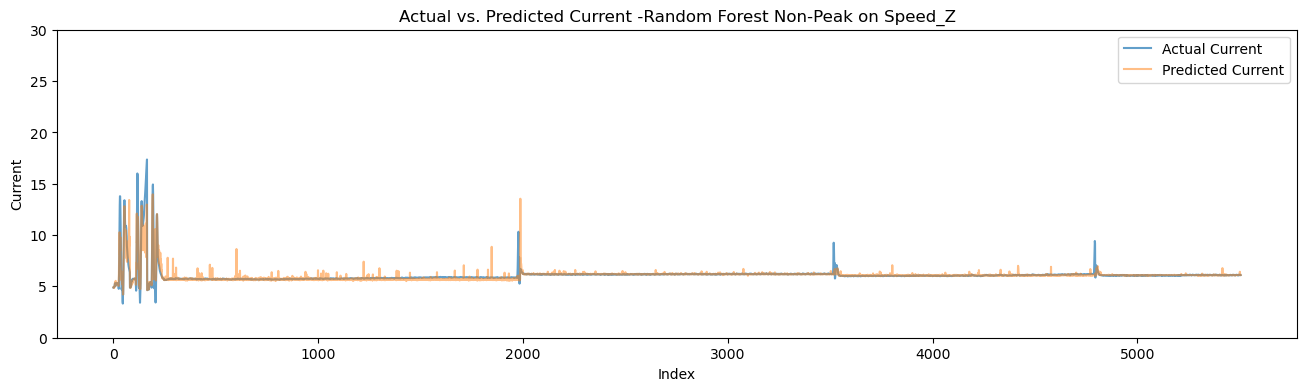

In [68]:
fit_predict(rf_model, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'Random Forest Non-Peak on '+ column_name)

Mean Absolute Error: 0.3716026033431641
Mean Squared Error: 1.3917058988706812
Root Mean Squared Error: 1.1797058526898478
R-squared Score: -0.21428115765385014
Mean Absolute Percentage Error: 5.954435303294665


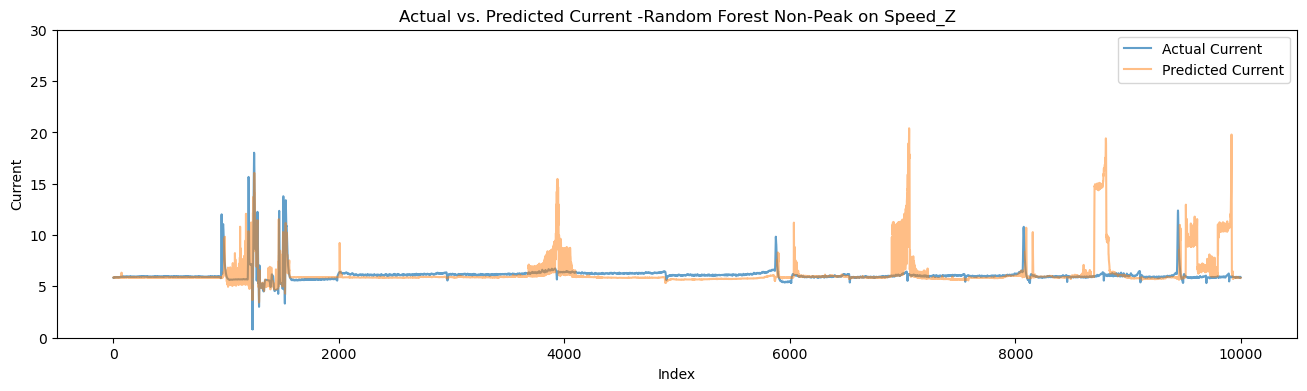

In [50]:
fit_predict(rf_model, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'Random Forest Non-Peak on '+ column_name)

Mean Absolute Error: 0.12099873771996217
Mean Squared Error: 0.23037262457496746
Root Mean Squared Error: 0.4799714830851594
R-squared Score: 0.675776845095738
Mean Absolute Percentage Error: 1.7288229811069225


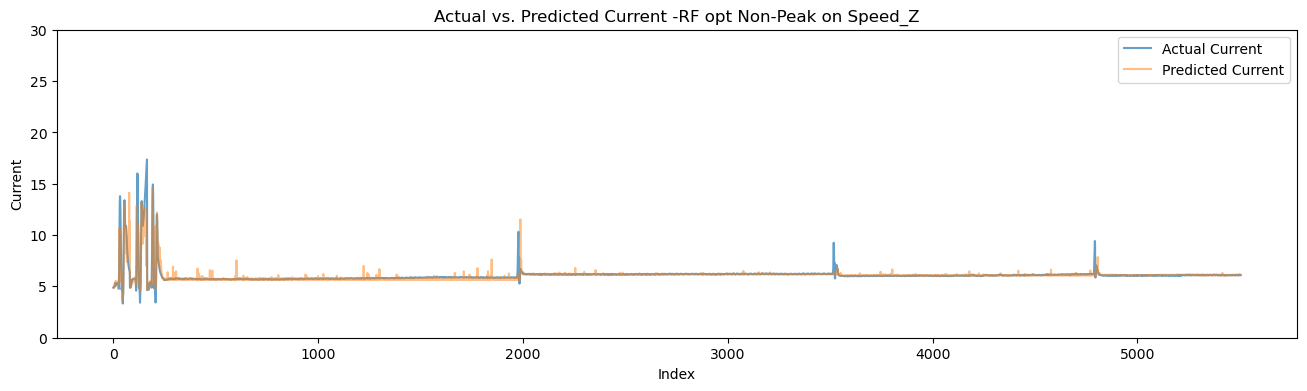

In [69]:
fit_predict(best_grid, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RF opt Non-Peak on '+ column_name)

Mean Absolute Error: 0.325445205454772
Mean Squared Error: 0.753237680636635
Root Mean Squared Error: 0.8678926665415689
R-squared Score: 0.34279051085854184
Mean Absolute Percentage Error: 5.209073604132415


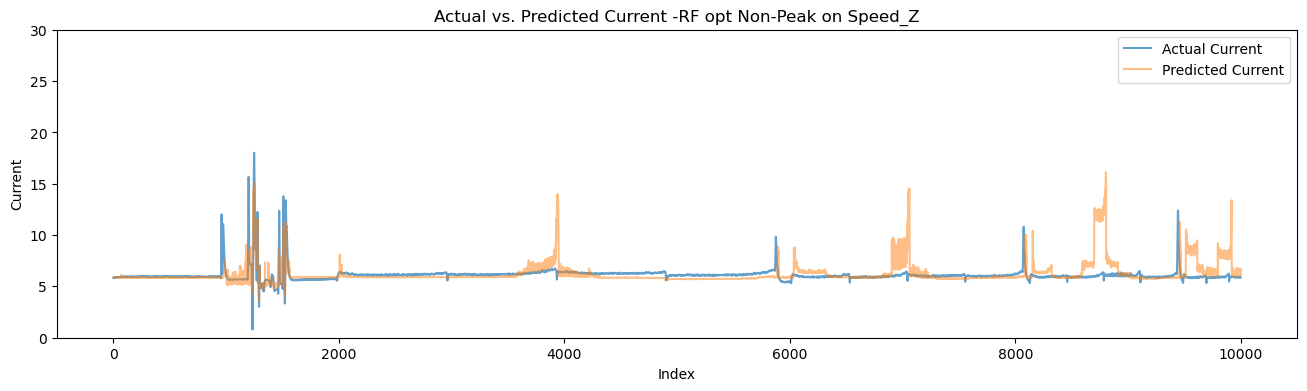

In [45]:
fit_predict(best_grid, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RF opt Non-Peak on '+ column_name)

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step
Mean Absolute Error: 0.2554802925448985
Mean Squared Error: 0.50452472842023
Root Mean Squared Error: 0.710299041545341
R-squared Score: -0.06430941091949816
Mean Absolute Percentage Error: 3.860243345051288


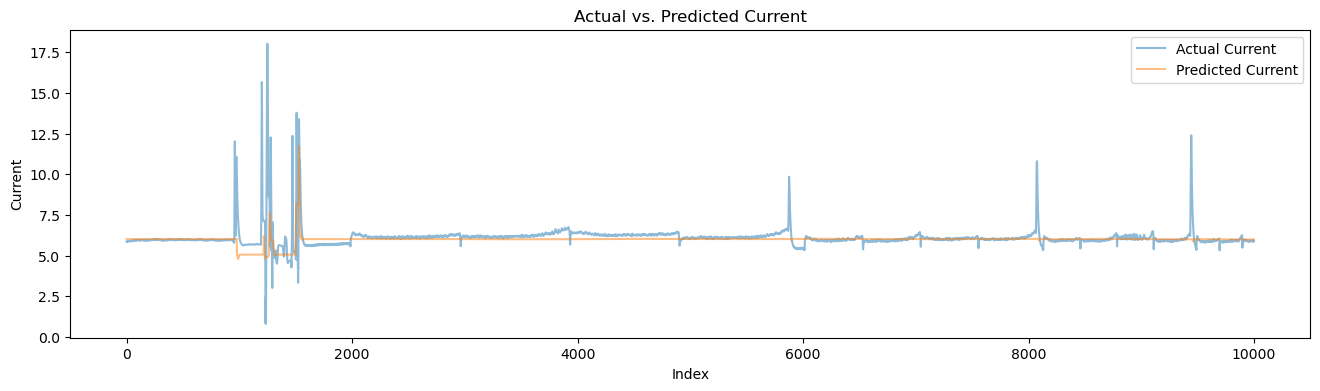

In [32]:
neural_nets(X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak)

Build and train a RF and NN model for peak data

Mean Absolute Error: 0.12337091172119892
Mean Squared Error: 0.2122865700805063
Root Mean Squared Error: 0.46074566745711926
R-squared Score: 0.6863202981296667
Mean Absolute Percentage Error: 1.9106302113330056


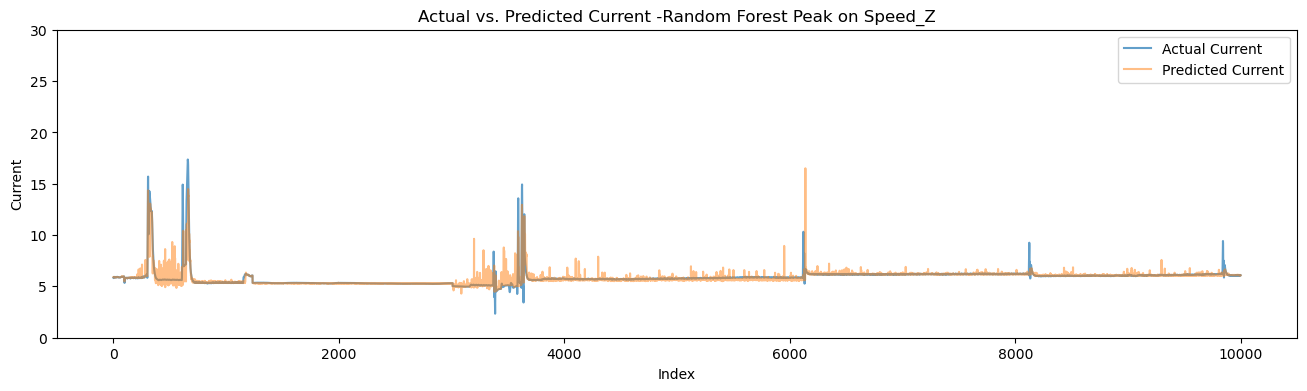

In [51]:
fit_predict(rf_model, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'Random Forest Peak on '+ column_name)

Mean Absolute Error: 0.11064367588064736
Mean Squared Error: 0.18504200815501842
Root Mean Squared Error: 0.43016509406856623
R-squared Score: 0.7265775129837854
Mean Absolute Percentage Error: 1.6940914287542403


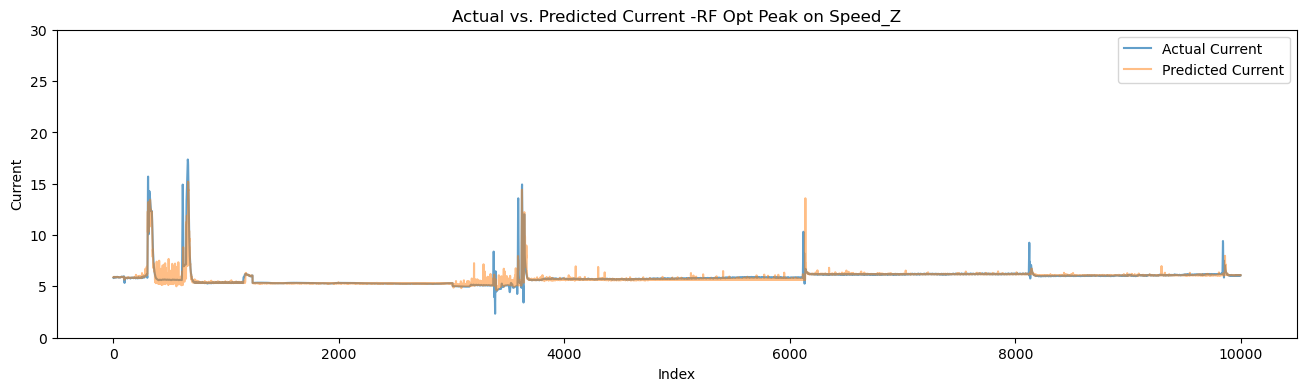

In [47]:
fit_predict(best_grid, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RF Opt Peak on '+ column_name)

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
Mean Absolute Error: 0.24204773813370847
Mean Squared Error: 0.7342413901382894
Root Mean Squared Error: 0.8568788654986709
R-squared Score: 0.39263921800906776
Mean Absolute Percentage Error: 3.5502707668177287


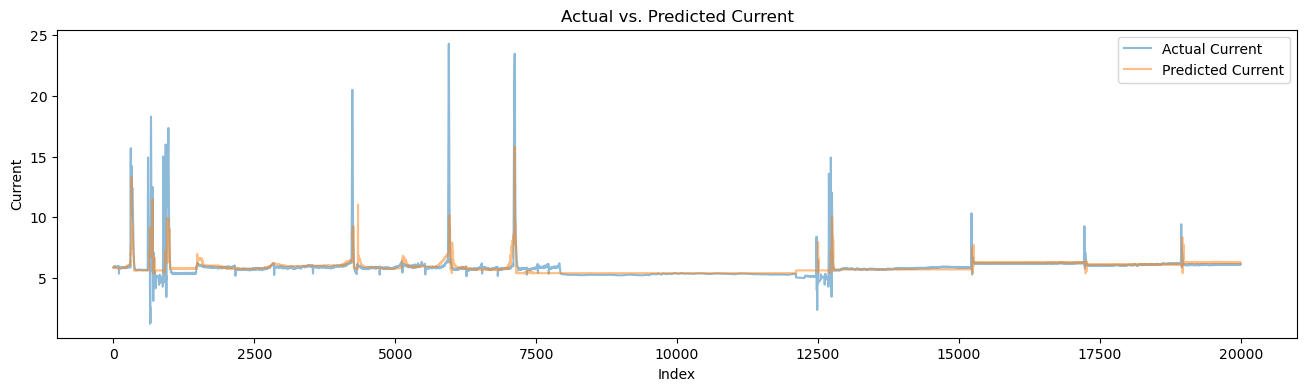

In [33]:
neural_nets(X_train_peak, X_test_peak, y_train_peak, y_test_peak)

| Model                   |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-------------------------|-------|-------|-------|-------|-------|
| General Random Forest   | 0.101 | 0.195 | 0.442 | 0.800 | 1.586 |
| General Neural Network  | 0.269 | 0.782 | 0.884 | 0.199 | 3.975 |
|                         |       |       |       |       |       |
| Global Random Forest    | 0.310 | 0.526 | 0.725 | -0.11 | 4.748 |
| Global Neural Network   | 9.148 | 2744. | 52.38 | -5787 | 167.7 |
|                         |       |       |       |       |       |
| Peak-Aware RF           | 0.108 | 0.191 | 0.437 | 0.841 | 1.720 |
| Peak-Aware NN           | 0.267 | 0.905 | 0.951 | 0.250 | 3.829 |

## Without using Global Models

Mean Absolute Error: 0.09048353246663692
Mean Squared Error: 0.19577784453151775
Root Mean Squared Error: 0.4424679022613027
R-squared Score: 0.8291813321380505
Mean Absolute Percentage Error: 1.4185122053495336


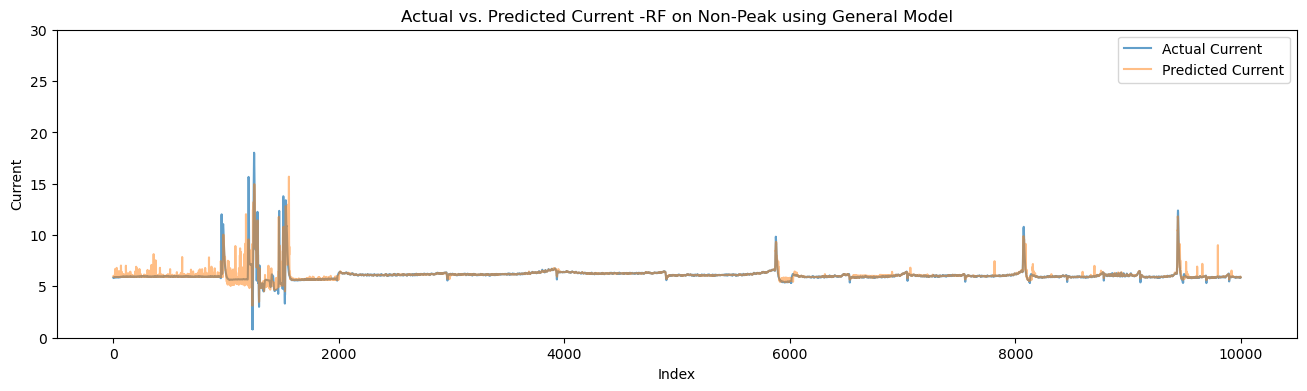

In [52]:
fit_predict(rf_model, X_train, X_test_non_peak, y_train, y_test_non_peak, 'RF on Non-Peak using General Model')

Mean Absolute Error: 0.11367341254481
Mean Squared Error: 0.23319627317947186
Root Mean Squared Error: 0.4829039999621787
R-squared Score: 0.7965332756103776
Mean Absolute Percentage Error: 1.7316185139922158


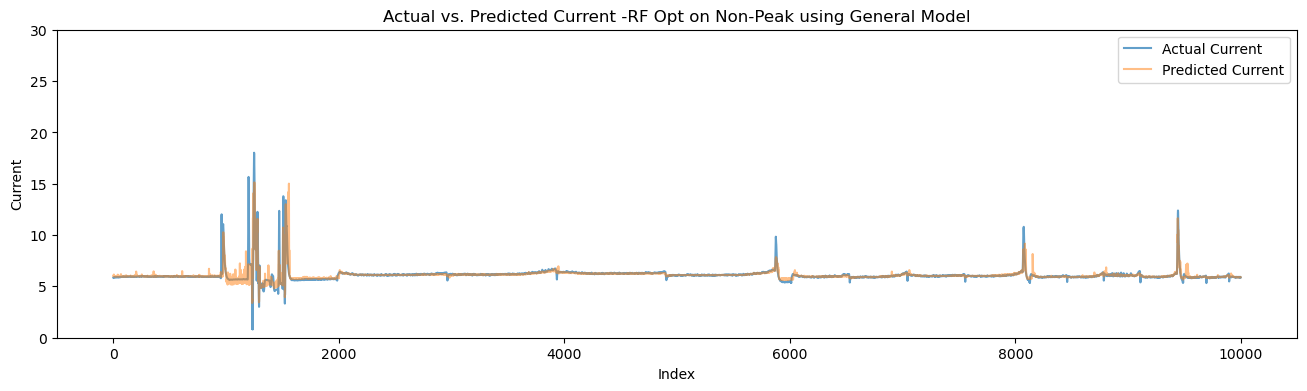

In [53]:
fit_predict(best_grid, X_train, X_test_non_peak, y_train, y_test_non_peak, 'RF Opt on Non-Peak using General Model')

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


738/738 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Absolute Error: 0.24045596072353048
Mean Squared Error: 0.7229464947779037
Root Mean Squared Error: 0.8502626034219686
R-squared Score: 0.21919714016874847
Mean Absolute Percentage Error: 3.653217143100046


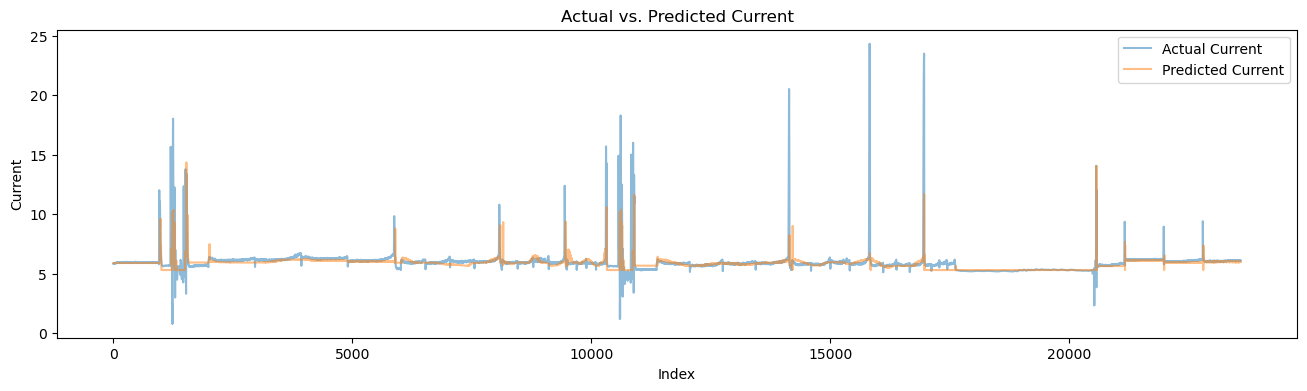

In [123]:
neural_nets(X_train, X_test_non_peak, y_train, y_test_non_peak)

General model for non-peak data and Peak-aware model for peak data

| Model                   |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-------------------------|-------|-------|-------|-------|-------|
| General Random Forest   | 0.101 | 0.195 | 0.442 | 0.800 | 1.586 |
| General Neural Network  | 0.269 | 0.782 | 0.884 | 0.199 | 3.975 |
|                         |       |       |       |       |       |
| Gen Non-Peak RF         | 0.092 | 0.186 | 0.431 | 0.798 | 1.463 |
| Gen Non-Peak NN         | 0.240 | 0.722 | 0.850 | 0.219 | 3.653 |
|                         |       |       |       |       |       |
| Peak-Aware RF           | 0.108 | 0.191 | 0.437 | 0.841 | 1.720 |
| Peak-Aware NN           | 0.267 | 0.905 | 0.951 | 0.250 | 3.829 |

## Using only one feature as dataset

In [54]:
X_train_f1 = X_train[[column_name]].copy()
X_test_f1 = X_test[[column_name]].copy()

X_train_peak_f1, y_train_peak_f1, X_train_non_peak_f1, y_train_non_peak_f1, X_test_peak_f1, y_test_peak_f1, X_test_non_peak_f1, y_test_non_peak_f1 = create_train_test_split(X_train_f1, y_train, X_test_f1, y_test, column_name)

Mean Absolute Error: 0.3652310717426718
Mean Squared Error: 0.9397565910632965
Root Mean Squared Error: 0.9694104347815204
R-squared Score: 0.038929734540576466
Mean Absolute Percentage Error: 5.686207691985812


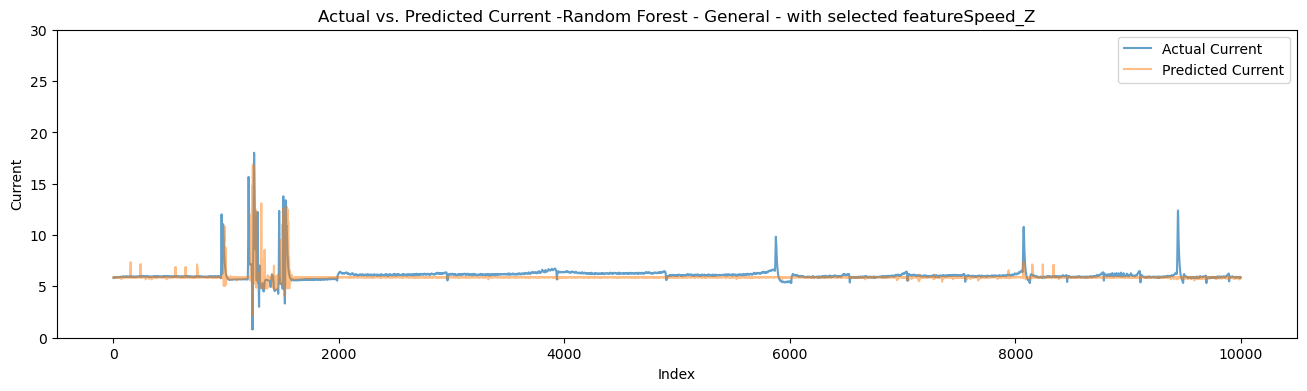

In [55]:
fit_predict(rf_model, X_train_f1, X_test_f1, y_train, y_test, 'Random Forest - General - with selected feature' + column_name)

Mean Absolute Error: 0.3690222187980235
Mean Squared Error: 1.026684147707714
Root Mean Squared Error: 1.0132542364617647
R-squared Score: -0.04996933861778596
Mean Absolute Percentage Error: 5.733255782577777


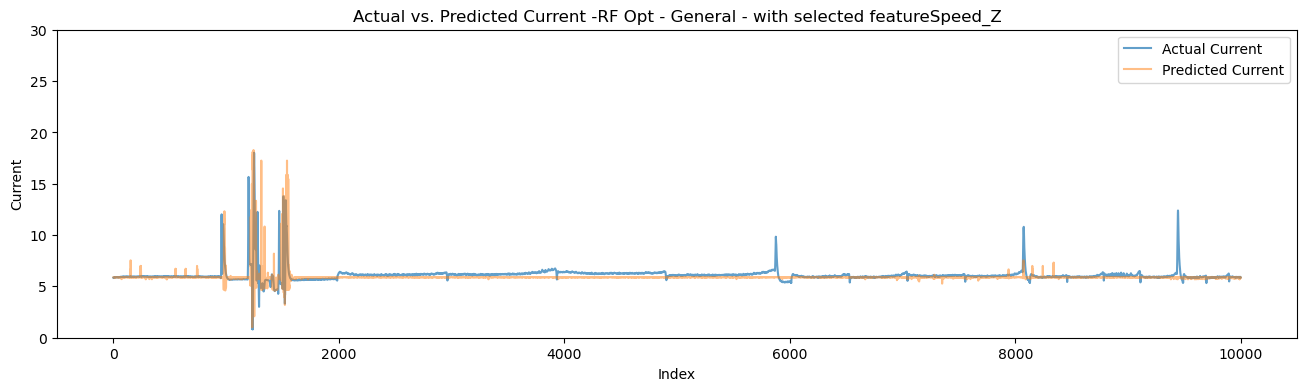

In [56]:
fit_predict(best_grid, X_train_f1, X_test_f1, y_train, y_test, 'RF Opt - General - with selected feature' + column_name)

Mean Absolute Error: 0.35128518875265974
Mean Squared Error: 1.0786442127302214
Root Mean Squared Error: 1.038577976239734
R-squared Score: 0.05886915878310517
Mean Absolute Percentage Error: 5.362292919525219


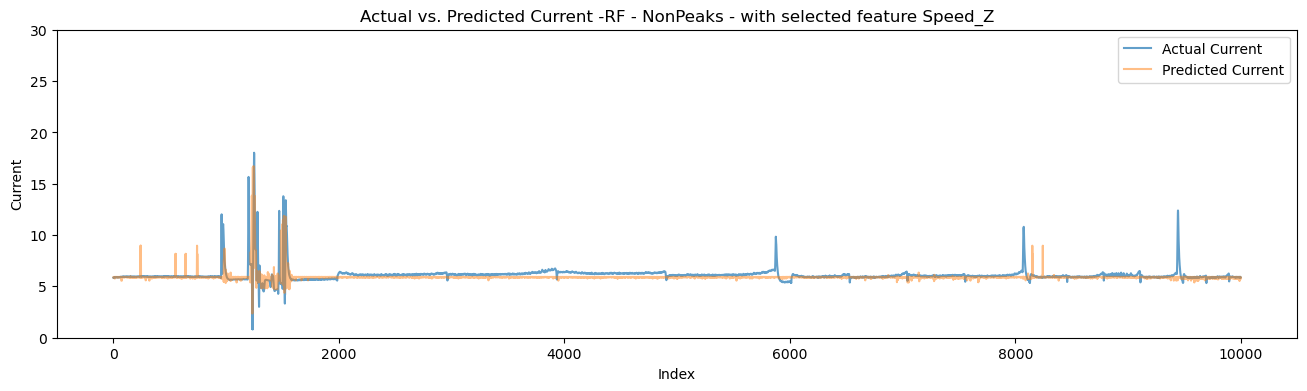

In [57]:
fit_predict(rf_model, X_train_non_peak_f1, X_test_non_peak_f1, y_train_non_peak_f1, y_test_non_peak_f1, 'RF - NonPeaks - with selected feature ' + column_name)

Mean Absolute Error: 0.3547413510842273
Mean Squared Error: 1.1686394645836546
Root Mean Squared Error: 1.0810362919826766
R-squared Score: -0.019652846974442584
Mean Absolute Percentage Error: 5.4144059820899475


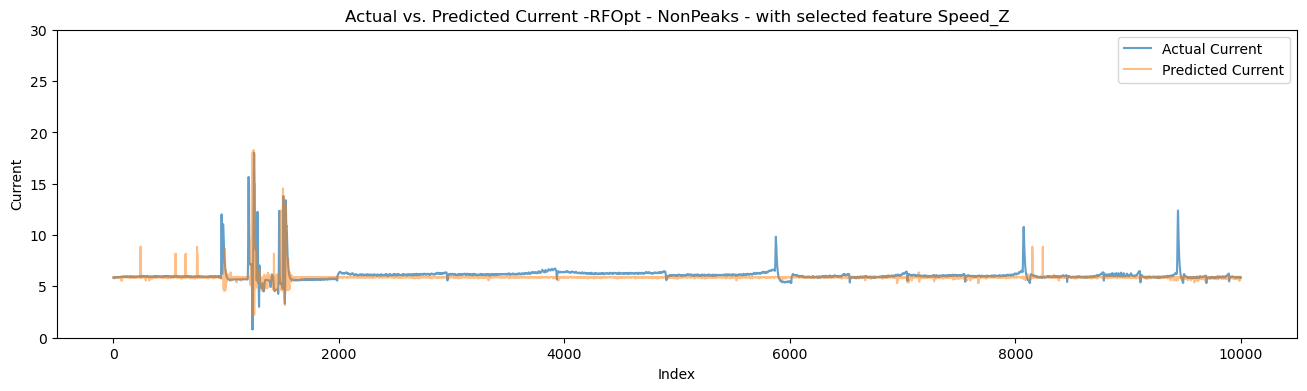

In [58]:
fit_predict(best_grid, X_train_non_peak_f1, X_test_non_peak_f1, y_train_non_peak_f1, y_test_non_peak_f1, 'RFOpt - NonPeaks - with selected feature ' + column_name)

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Absolute Error: 3.0202598946286945
Mean Squared Error: 1561.2358326703845
Root Mean Squared Error: 39.51247692400952
R-squared Score: -3292.471847413222
Mean Absolute Percentage Error: 62.8484386793107


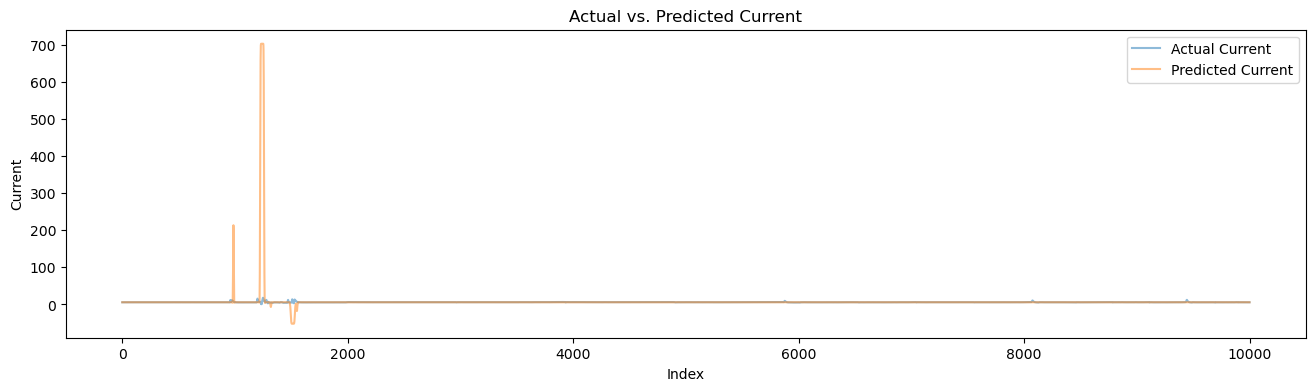

In [26]:
neural_nets(X_train_non_peak_f1, X_test_non_peak_f1, y_train_non_peak_f1, y_test_non_peak_f1)

Mean Absolute Error: 0.3777947549893462
Mean Squared Error: 0.588090166060659
Root Mean Squared Error: 0.766870371093224
R-squared Score: 0.13102393668697787
Mean Absolute Percentage Error: 6.193026639792974


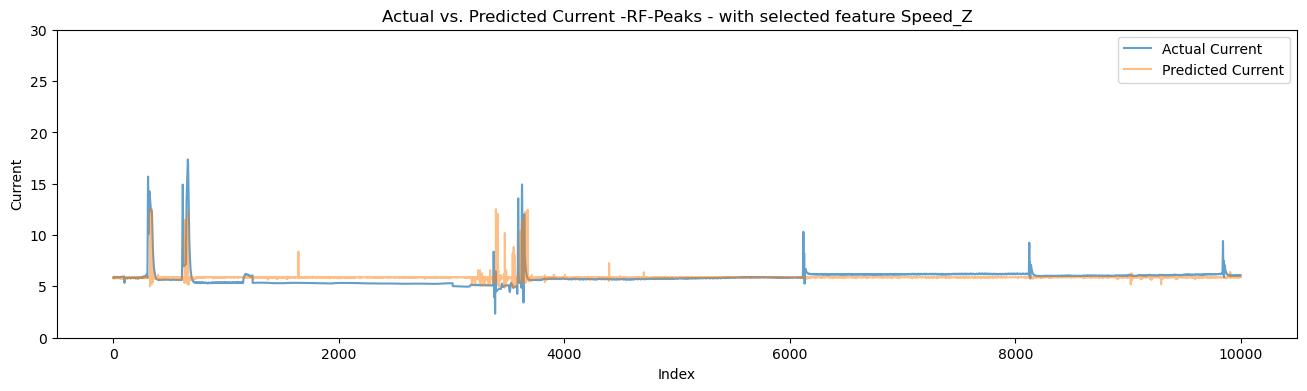

In [59]:
fit_predict(rf_model, X_train_peak_f1, X_test_peak_f1, y_train_peak_f1, y_test_peak_f1, 'RF-Peaks - with selected feature ' + column_name)

Mean Absolute Error: 0.3769960674179936
Mean Squared Error: 0.6413478592909841
Root Mean Squared Error: 0.8008419689870057
R-squared Score: 0.052329098250167516
Mean Absolute Percentage Error: 6.166840765075555


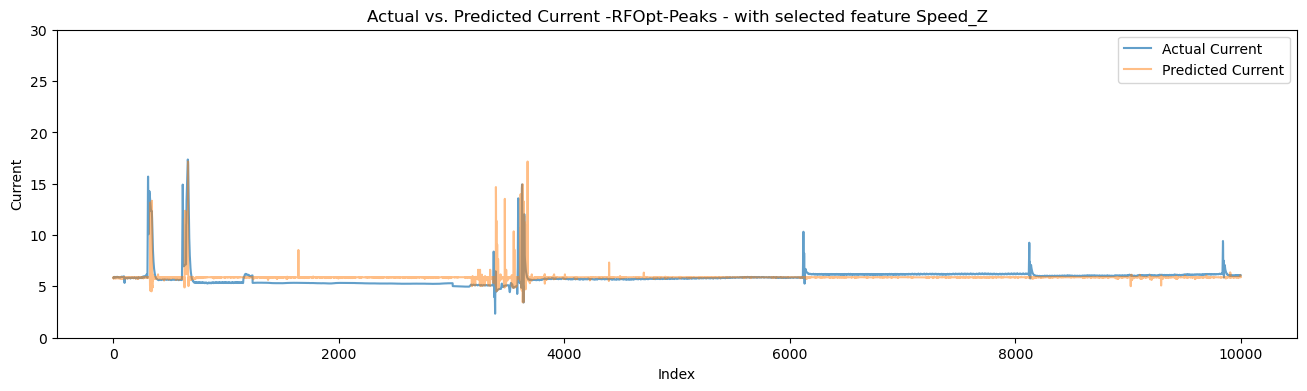

In [60]:
fit_predict(best_grid, X_train_peak_f1, X_test_peak_f1, y_train_peak_f1, y_test_peak_f1, 'RFOpt-Peaks - with selected feature ' + column_name)

d:\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Absolute Error: 0.39766462275282644
Mean Squared Error: 1.1510973250304297
Root Mean Squared Error: 1.0728920379192073
R-squared Score: 0.0478180869829804
Mean Absolute Percentage Error: 6.084954823358763


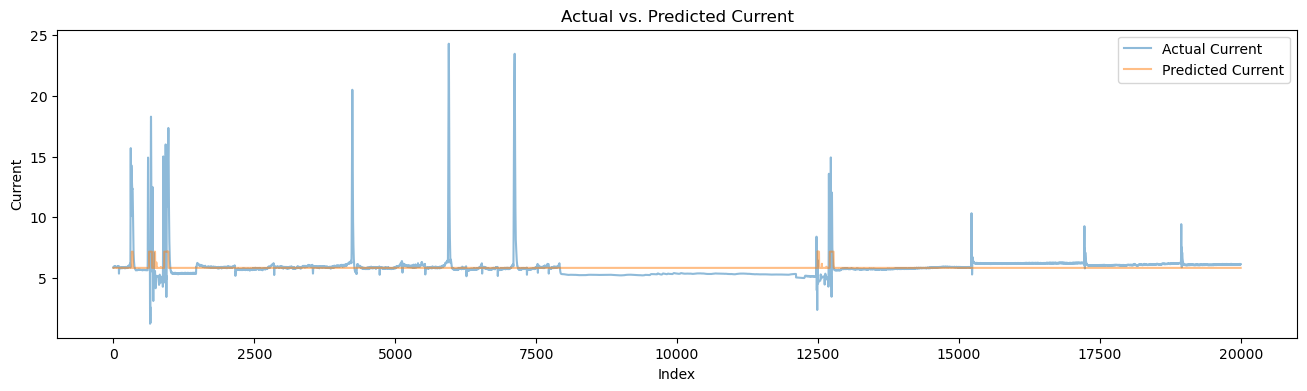

In [28]:
neural_nets(X_train_peak_f1, X_test_peak_f1, y_train_peak_f1, y_test_peak_f1)

| Model                   |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-------------------------|-------|-------|-------|-------|-------|
| General Random Forest   | 0.101 | 0.195 | 0.442 | 0.800 | 1.586 |
| General Neural Network  | 0.269 | 0.782 | 0.884 | 0.199 | 3.975 |
|                         |       |       |       |       |       |
| Global Random Forest    | 0.272 | 0.572 | 0.756 | -0.20 | 4.059 |
|  Global Neural Network  | 3.020 | 1561. | 39.51 | -3292 | 62.84 |
|                         |       |       |       |       |       |
| Peak-Aware RF           | 0.395 | 1.136 | 1.066 | 0.059 | 6.114 |
|  Peak-Aware NN          | 0.397 | 1.151 | 1.072 | 0.047 | 6.084 |

## Using Speed_X

In [61]:
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = create_train_test_split(X_train, y_train, X_test, y_test, 'Speed_X')

Mean Absolute Error: 0.2775508033480573
Mean Squared Error: 0.5379581084507616
Root Mean Squared Error: 0.7334562757593405
R-squared Score: 0.1704394553600923
Mean Absolute Percentage Error: 4.535492285455888


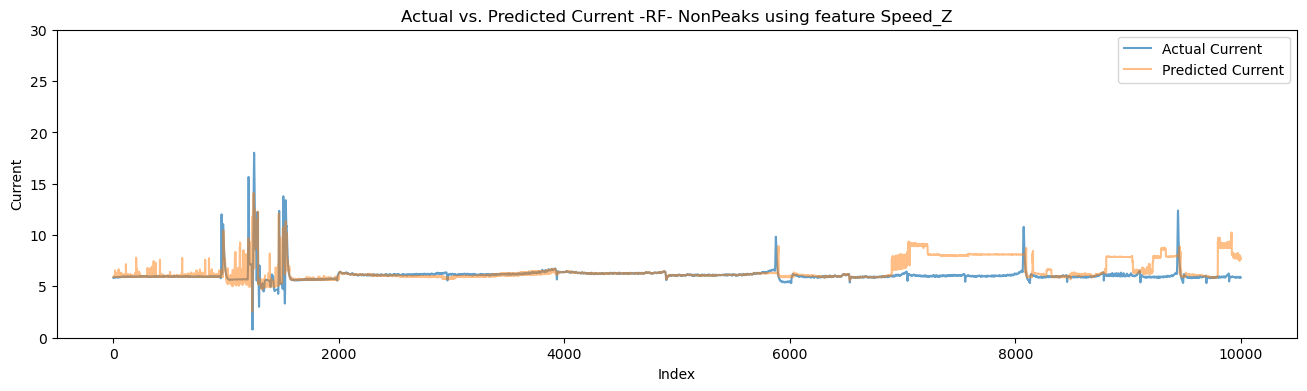

In [62]:
fit_predict(rf_model, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RF- NonPeaks using feature ' + column_name)

Mean Absolute Error: 0.18874170036694313
Mean Squared Error: 0.3284603155968579
Root Mean Squared Error: 0.5731145745807359
R-squared Score: 0.49349640052118515
Mean Absolute Percentage Error: 2.9861187290481017


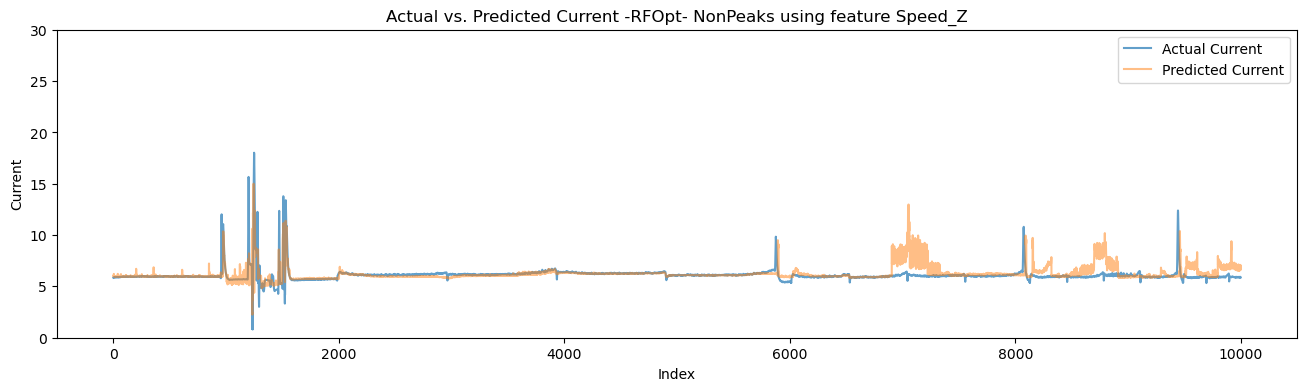

In [64]:
fit_predict(best_grid, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RFOpt- NonPeaks using feature ' + column_name)

Mean Absolute Error: 0.150483247462826
Mean Squared Error: 0.361281602766074
Root Mean Squared Error: 0.60106705346914
R-squared Score: 0.810858348925242
Mean Absolute Percentage Error: 2.39881690725001


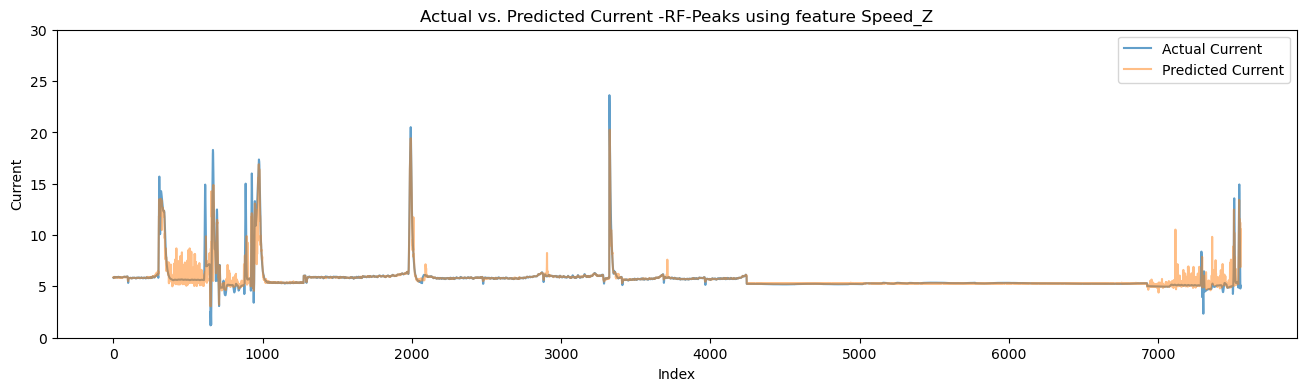

In [63]:
fit_predict(rf_model, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RF-Peaks using feature ' + column_name)

Mean Absolute Error: 0.14893404624604192
Mean Squared Error: 0.3504199651697649
Root Mean Squared Error: 0.5919628072520814
R-squared Score: 0.8165447388565659
Mean Absolute Percentage Error: 2.3320353593146668


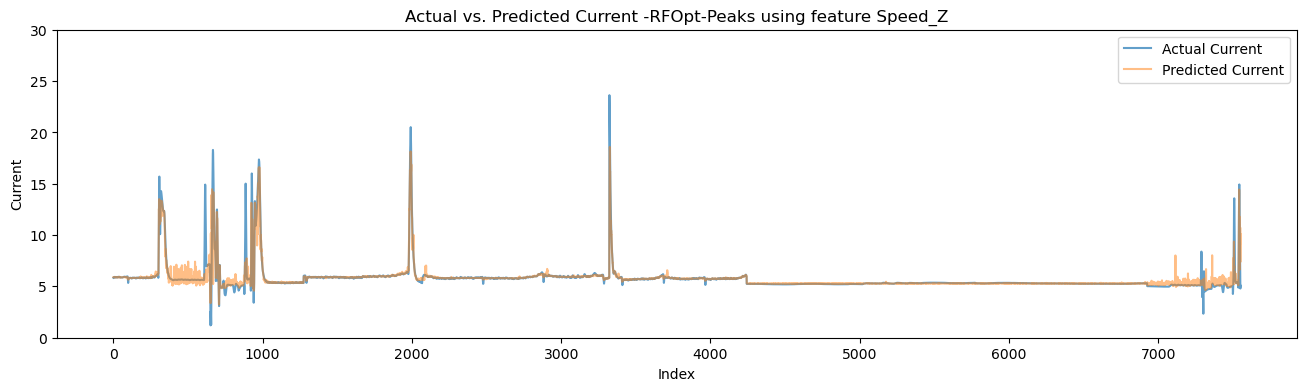

In [65]:
fit_predict(best_grid, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RFOpt-Peaks using feature ' + column_name)

Peak-Aware RF model based on feature 'Speed_X'

| Model                   |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-------------------------|-------|-------|-------|-------|-------|
| General Random Forest   | 0.101 | 0.195 | 0.442 | 0.800 | 1.586 |
| General Neural Network  | 0.269 | 0.782 | 0.884 | 0.199 | 3.975 |
|                         |       |       |       |       |       |
| Peak-Aware RF Peaks     | 1.828 | 6.580 | 2.565 | 0.436 | 28.18 |
| Peak-Aware RF Non-Peaks | 0.100 | 0.194 | 0.441 | 0.798 | 1.557 |

## Using Accel_SP

In [67]:
X_train_peak, y_train_peak, X_train_non_peak, y_train_non_peak, X_test_peak, y_test_peak, X_test_non_peak, y_test_non_peak = create_train_test_split(X_train, y_train, X_test, y_test, 'Accel_SP')

Mean Absolute Error: 0.08656710720092725
Mean Squared Error: 0.17660227450618554
Root Mean Squared Error: 0.42024073399206024
R-squared Score: 0.7466576892008963
Mean Absolute Percentage Error: 1.320352257458126


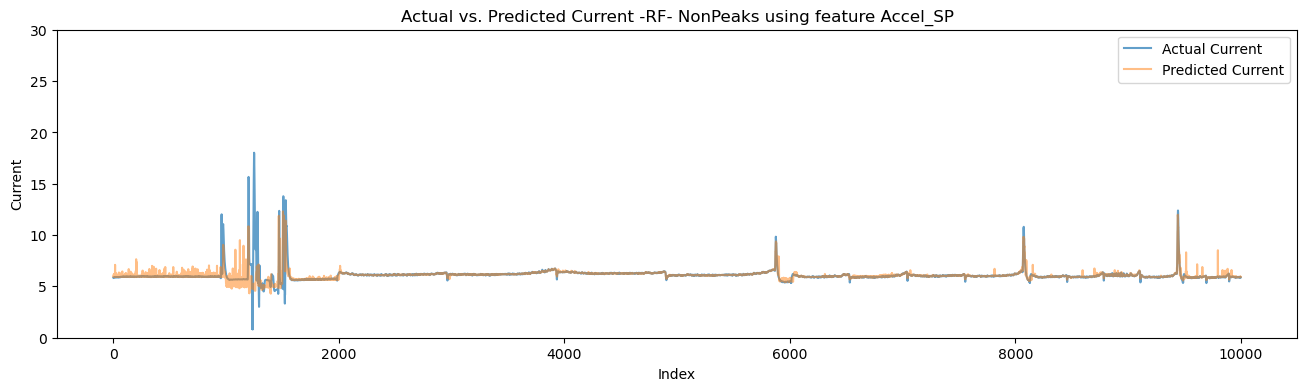

In [68]:
fit_predict(rf_model, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RF- NonPeaks using feature Accel_SP')

Mean Absolute Error: 0.09941362007419137
Mean Squared Error: 0.20639821645149609
Root Mean Squared Error: 0.4543107047511605
R-squared Score: 0.7039143394565728
Mean Absolute Percentage Error: 1.4783109240041012


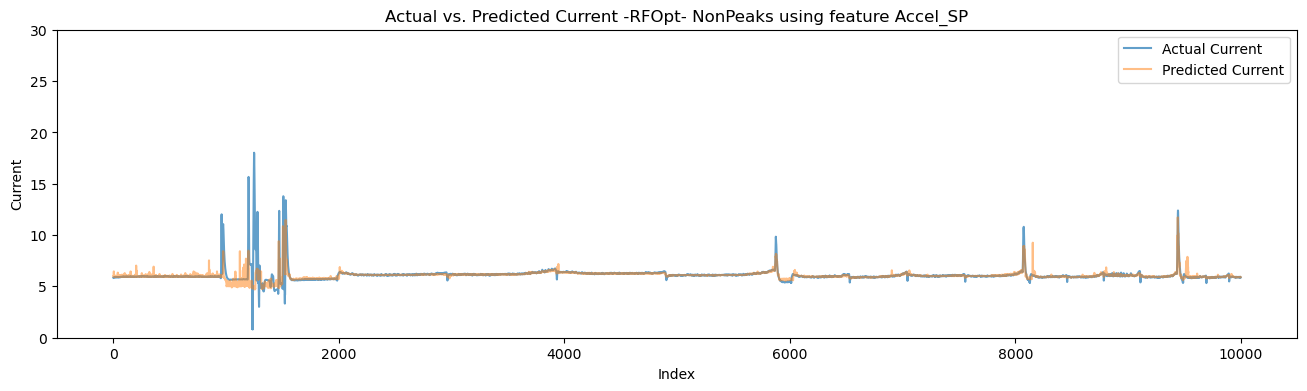

In [69]:
fit_predict(best_grid, X_train_non_peak, X_test_non_peak, y_train_non_peak, y_test_non_peak, 'RFOpt- NonPeaks using feature Accel_SP')

Mean Absolute Error: 0.7016972486181142
Mean Squared Error: 2.3079026184173586
Root Mean Squared Error: 1.5191782707823853
R-squared Score: 0.7042122829304325
Mean Absolute Percentage Error: 10.351568383633353


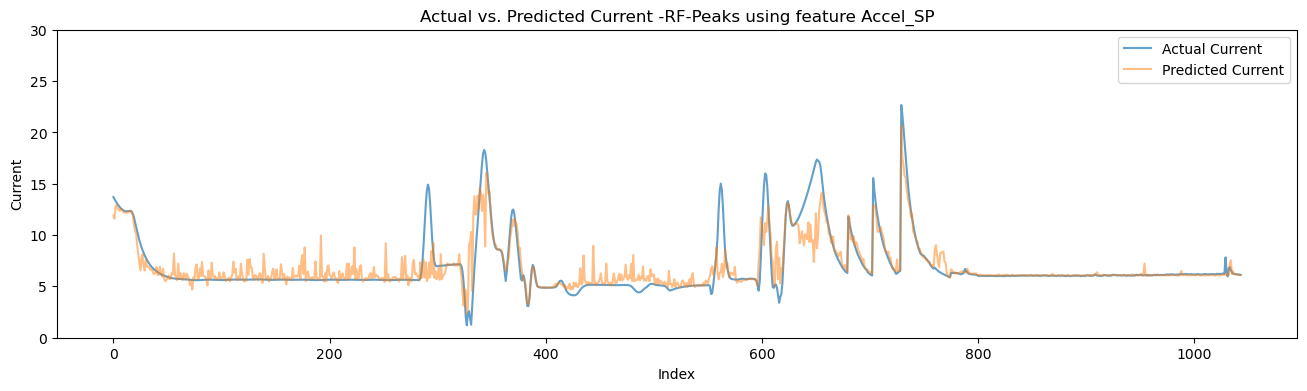

In [70]:
fit_predict(rf_model, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RF-Peaks using feature Accel_SP')

Mean Absolute Error: 0.6466597803549067
Mean Squared Error: 2.27040355125684
Root Mean Squared Error: 1.5067858345686822
R-squared Score: 0.7090182757739496
Mean Absolute Percentage Error: 9.43901414471654


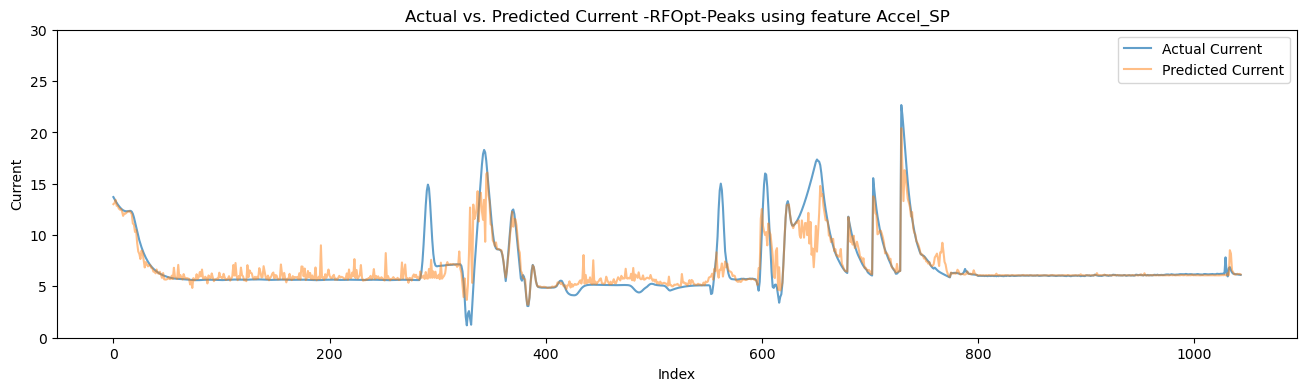

In [71]:
fit_predict(best_grid, X_train_peak, X_test_peak, y_train_peak, y_test_peak, 'RFOpt-Peaks using feature Accel_SP')

RF for Peaks and NonPeaks using the feature 'Accel_SP'

| Model           |  MAE  |  MSE  |  RMSE |   R2  | MAPE  |
|-----------------|-------|-------|-------|-------|-------|
| RF Peak         | 0.190 | 0.323 | 0.568 | 0.722 | 3.082 |
| RF Non-Peak     | 0.094 | 0.183 | 0.428 | 0.801 | 1.470 |


# Investigation

In [11]:
def plot_feature(x, title):
    plt.figure(figsize=(16, 4))
    x_values = np.arange(50000)
    plt.plot(x_values, x[:50000])
    plt.ylim(-5, 5)  # Set y-axis limits from 0 to 30
    plt.xlabel('Index')
    plt.ylabel(title)
    plt.title('Plot of feature - ' + title)
    plt.show()

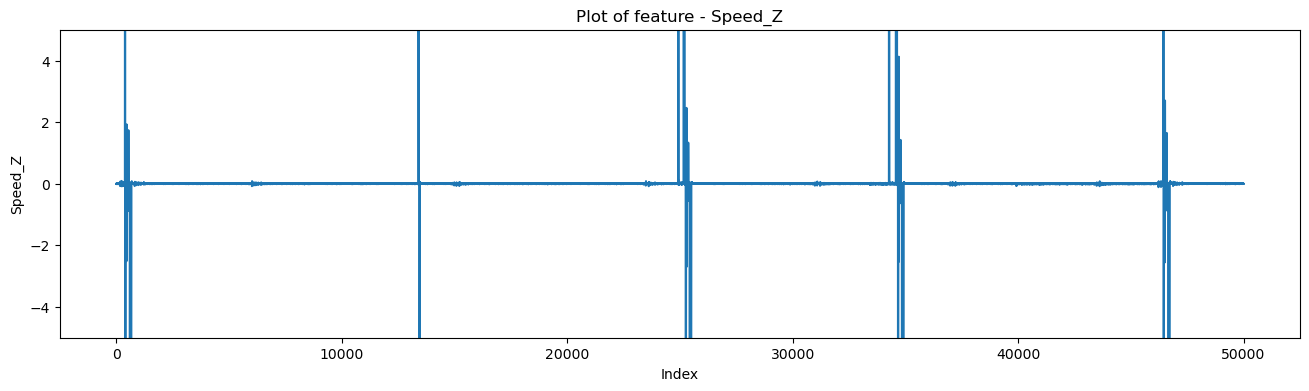

In [12]:
plot_feature(df['Speed_Z'], 'Speed_Z')

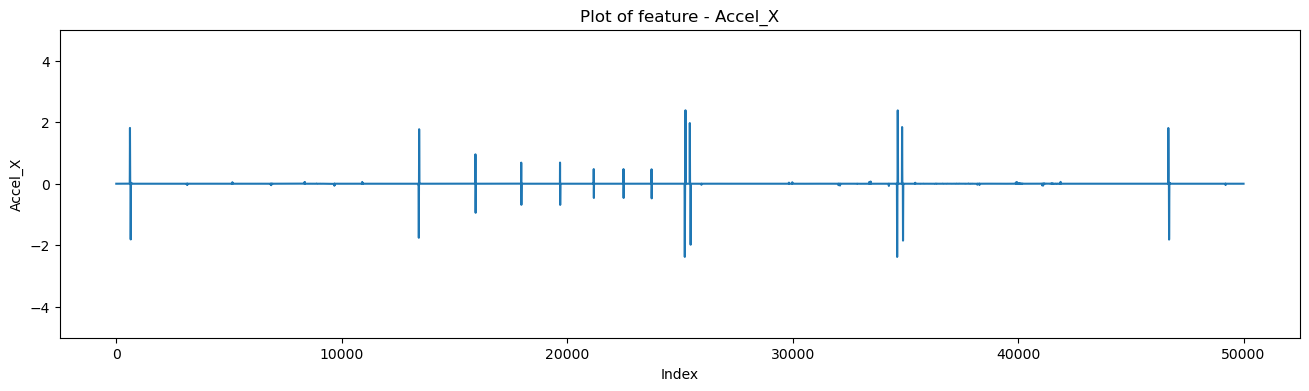

In [13]:
plot_feature(df['Accel_X'], 'Accel_X')

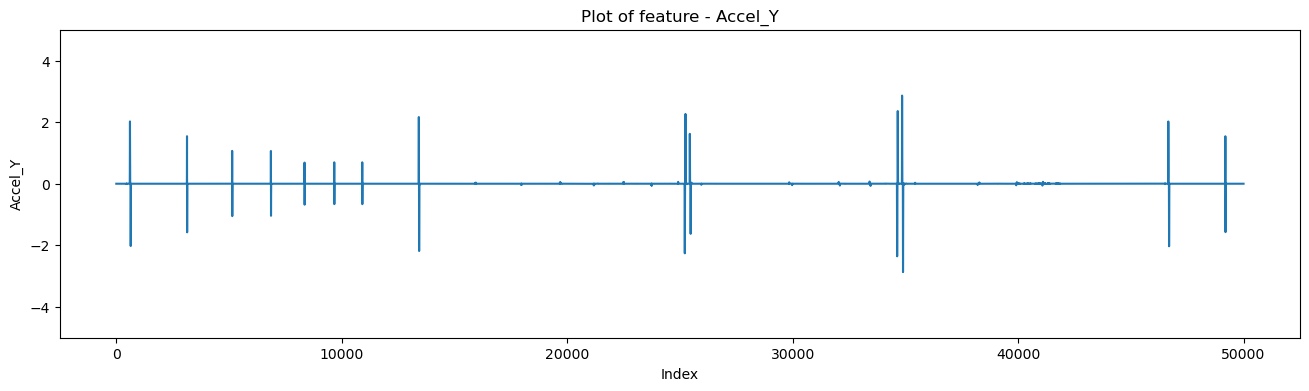

In [14]:
plot_feature(df['Accel_Y'], 'Accel_Y')

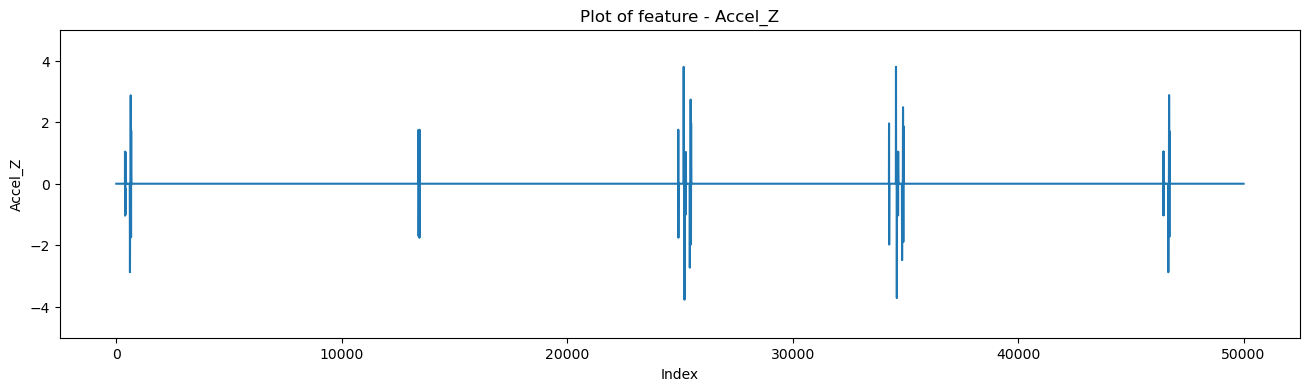

In [15]:
plot_feature(df['Accel_Z'], 'Accel_Z')

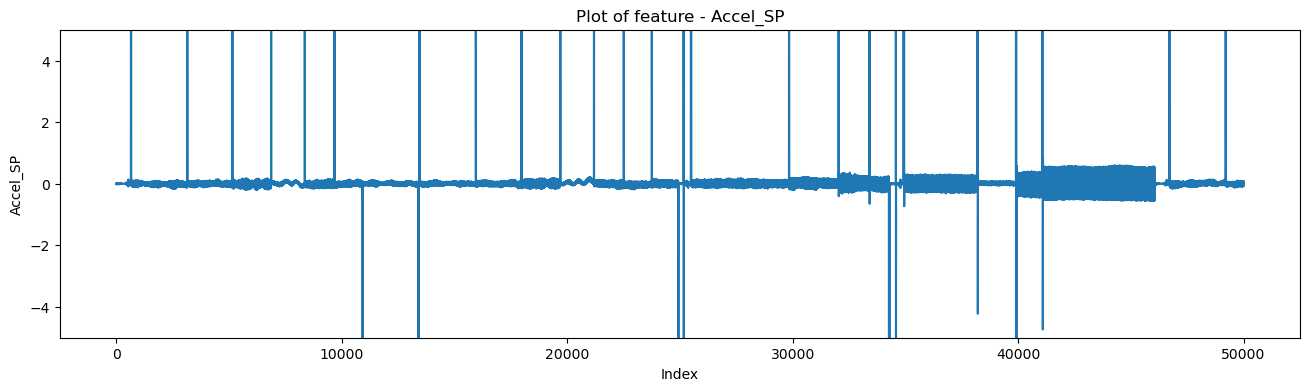

In [16]:
plot_feature(df['Accel_SP'], 'Accel_SP')